# COMP90051 Project


## C0： Globle Config

In [ ]:
# C0 - Global config
from pathlib import Path
import os, random, numpy as np

SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Paths
DATA_DIR    = Path("data");     DATA_DIR.mkdir(parents=True, exist_ok=True)
UNIFIED_DIR = Path("unified");  UNIFIED_DIR.mkdir(parents=True, exist_ok=True)
BY_FOLD_DIR = UNIFIED_DIR / "by_fold"; BY_FOLD_DIR.mkdir(parents=True, exist_ok=True)

FUSION_DIR   = Path("fusion_results");             FUSION_DIR.mkdir(parents=True, exist_ok=True)
BERT_PROB_DIR= FUSION_DIR / "bert_probs";          BERT_PROB_DIR.mkdir(parents=True, exist_ok=True)
UNI_OUT      = FUSION_DIR / "unified";             UNI_OUT.mkdir(parents=True, exist_ok=True)
FIG_DIR      = Path("figures");                    FIG_DIR.mkdir(parents=True, exist_ok=True)
RUNS_DIR     = Path("runs_bert");                  RUNS_DIR.mkdir(parents=True, exist_ok=True)

CLEAN_CSV = DATA_DIR / "cleaned_toxic_data.csv"
SUBSET_CSV= DATA_DIR / "subset_30k.csv"
FOLDS_JSON= DATA_DIR / "folds_10.json"
HP_LOG    = FUSION_DIR / "hp_logs" / "hp_best_by_fold.csv"

# Sampling and folds
SUBSET_N  = 30000
N_OUTER   = 10
N_INNER   = 3

# Noise levels
NOISE_P_LEVELS = [0.05, 0.10, 0.20]

# Model and grid
MODEL_NAME = "bert-base-uncased"   # define first, then tokenizer
MAX_LEN    = 256
TFIDF_CONFIG = dict(max_features=10000, min_df=5, max_df=0.7, ngram_range=(1,2),
                    strip_accents='unicode', lowercase=True, analyzer='word',
                    token_pattern=r'\b[a-zA-Z]{2,}\b', sublinear_tf=True)
BASE_MODEL_CONFIG = dict(max_iter=1000, tol=1e-4, verbose=0)
LR_PARAM_GRID     = {"C":[0.01,0.1,0.5,1.0,10.0,100.0], "penalty":["l1","l2"]}
BERT_PARAM_GRID   = {"lr":[3e-5,5e-5,7e-5], "batch":[16], "epochs":[2]}
FUSION_PARAM_GRID = {"alpha":[0.0,0.2,0.5,0.8,1.0], "K":[32],
                     "temperature":[0.05,0.10,0.15], "tau":[0.5]}

USE_INNER_SEARCH = True
SAVE_PRED_CSV    = False
USE_NOISE_TEST   = True
FIXED_HP         = {"lr":5e-5, "batch":16, "epochs":2}

# Tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

## C1: Common utilities



In [ ]:
# C1 - Common utilities
import numpy as np
import pandas as pd
import time
import json
from pathlib import Path

def precision_recall_f1_macro(y_true, y_prob, tau=0.5):
    """Calculate precision, recall, F1-macro from probabilities"""
    y_pred = (y_prob >= tau).astype(int)
    y_true = np.asarray(y_true, int)

    # Calculate for each class (0 and 1)
    metrics = {}
    for cls in [0, 1]:
        tp = ((y_pred == cls) & (y_true == cls)).sum()
        fp = ((y_pred == cls) & (y_true != cls)).sum()
        fn = ((y_pred != cls) & (y_true == cls)).sum()

        prec = tp / max(tp + fp, 1e-12)
        rec = tp / max(tp + fn, 1e-12)
        f1 = 2 * prec * rec / max(prec + rec, 1e-12)

        metrics[f'prec_{cls}'] = prec
        metrics[f'rec_{cls}'] = rec
        metrics[f'f1_{cls}'] = f1

    # Macro averages
    metrics['prec_macro'] = (metrics['prec_0'] + metrics['prec_1']) / 2
    metrics['rec_macro'] = (metrics['rec_0'] + metrics['rec_1']) / 2
    metrics['f1_macro'] = (metrics['f1_0'] + metrics['f1_1']) / 2

    # Overall accuracy
    metrics['acc'] = (y_pred == y_true).mean()

    return metrics

def roc_auc_from_scores(y_true, y_prob):
    """
    Calculate ROC-AUC score manually (without sklearn)
    Uses the probabilistic interpretation:
    AUC = P(score(positive) > score(negative))
    """
    try:
        y_true = np.asarray(y_true, dtype=int)
        y_prob = np.asarray(y_prob, dtype=float)

        # Get indices of positive and negative samples
        pos_indices = np.where(y_true == 1)[0]
        neg_indices = np.where(y_true == 0)[0]

        n_pos = len(pos_indices)
        n_neg = len(neg_indices)

        if n_pos == 0 or n_neg == 0:
            return float('nan')

        # Get scores for positive and negative samples
        pos_scores = y_prob[pos_indices]
        neg_scores = y_prob[neg_indices]

        # Count pairs where positive score > negative score
        # Using broadcasting for efficiency
        # pos_scores[:, None] creates shape (n_pos, 1)
        # neg_scores creates shape (n_neg,)
        # Broadcasting creates (n_pos, n_neg) comparison matrix
        comparisons = pos_scores[:, None] > neg_scores
        n_correct = comparisons.sum()

        # Count ties (positive score == negative score)
        ties = (pos_scores[:, None] == neg_scores).sum()

        # AUC = (correct + 0.5 * ties) / total_pairs
        auc = (n_correct + 0.5 * ties) / (n_pos * n_neg)

        return float(auc)

    except Exception as e:
        print(f"Warning: ROC-AUC calculation failed: {e}")
        return float('nan')

def average_precision_from_scores(y_true, y_prob):
    """
    Calculate Average Precision (AUPR) manually (without sklearn)
    AP = sum(precision_i * recall_change_i)
    """
    try:
        y_true = np.asarray(y_true, dtype=int)
        y_prob = np.asarray(y_prob, dtype=float)

        # Number of positive samples
        n_pos = (y_true == 1).sum()

        if n_pos == 0:
            return float('nan')

        # Sort by predicted probability (descending)
        sort_indices = np.argsort(-y_prob)  # negative for descending
        y_true_sorted = y_true[sort_indices]

        # Calculate precision at each threshold
        # tp_cumsum[i] = number of true positives in top i+1 predictions
        tp_cumsum = np.cumsum(y_true_sorted)

        # Precision at each position
        # precision[i] = tp / (i+1)
        positions = np.arange(1, len(y_true_sorted) + 1)
        precisions = tp_cumsum / positions

        # Recall at each position
        # recall[i] = tp / n_pos
        recalls = tp_cumsum / n_pos

        # Calculate recall changes (for positive samples only)
        # AP = sum(precision * delta_recall) where delta_recall occurs at positive samples
        recall_changes = np.zeros(len(recalls))
        recall_changes[0] = recalls[0]
        recall_changes[1:] = recalls[1:] - recalls[:-1]

        # Only count recall changes at true positive positions
        ap = (precisions * recall_changes * y_true_sorted).sum()

        return float(ap)

    except Exception as e:
        print(f"Warning: Average Precision calculation failed: {e}")
        return float('nan')

def full_metrics(y_true, y_prob, tau=0.5):
    """Compute all metrics: P/R/F1 + ROC-AUC + AUPR (all manual implementation)"""
    base = precision_recall_f1_macro(y_true, y_prob, tau=tau)
    base.update(
        roc_auc=roc_auc_from_scores(y_true, y_prob),
        aupr=average_precision_from_scores(y_true, y_prob)
    )
    return base

def save_fold_metrics(model_name, split_name, fid, y_true, y_prob, tau=0.5):
    """Save metrics for single fold to CSV"""
    m = full_metrics(y_true, y_prob, tau=tau)
    row = dict(model=model_name, split=split_name, fold=fid, tau=tau, **m)
    out_dir = UNI_OUT / "by_fold"
    out_dir.mkdir(parents=True, exist_ok=True)
    (out_dir / f"{model_name}_{split_name}_fold{fid}.csv").write_text(
        pd.DataFrame([row]).to_csv(index=False)
    )
    return m

def stratified_kfold_indices(y, n_splits=3, seed=42):
    """Manual stratified k-fold split, returns train/val indices"""
    rng = np.random.default_rng(seed)
    y = np.asarray(y, int)
    pos = np.where(y==1)[0].tolist()
    neg = np.where(y==0)[0].tolist()
    rng.shuffle(pos)
    rng.shuffle(neg)
    buckets = [ ([],[]) for _ in range(n_splits) ]
    for i, idx in enumerate(pos):
        buckets[i % n_splits][0].append(idx)
    for i, idx in enumerate(neg):
        buckets[i % n_splits][1].append(idx)
    all_idx = set(range(len(y)))
    splits = []
    for k in range(n_splits):
        va_idx = np.array(buckets[k][0] + buckets[k][1], dtype=int)
        tr_idx = np.array(sorted(list(all_idx - set(va_idx))), dtype=int)
        splits.append((tr_idx, va_idx))
    return splits

def noise_tag(p: float) -> str:
    """Generate noise level tag like 'noisy_p005'"""
    return f"noisy_p{int(round(p*100)):03d}"

class Timer:
    """Context manager for timing code blocks"""
    def __enter__(self):
        self.t0 = time.time()
        return self
    def __exit__(self, *exc):
        self.dt = time.time() - self.t0

def log_best_params(model_name: str, fid: int, hp_dict: dict, score: float):
    """Log best hyperparameters for each fold"""

    hp_log_dir = FUSION_DIR / "hp_logs"
    hp_log_dir.mkdir(parents=True, exist_ok=True)

    row = {"model": model_name, "fold": fid, "score": score}

    for k, v in hp_dict.items():
        row[f"hp_{k}"] = v

    hp_log_file = hp_log_dir / "hp_best_by_fold.csv"
    df_row = pd.DataFrame([row])

    if hp_log_file.exists():
        df_existing = pd.read_csv(hp_log_file)
        df_combined = pd.concat([df_existing, df_row], ignore_index=True)
        df_combined.to_csv(hp_log_file, index=False)
    else:
        df_row.to_csv(hp_log_file, index=False)

print(" C1 Common utilities loaded (Manual metrics implementation)")

 C1 Common utilities loaded (Manual metrics implementation)


## C2: Data loading, cleaning, sampling, and partitioning


C2.1 Data Cleaning

In [ ]:
# Data cleaning
import pandas as pd
import numpy as np, cupy as cp
import re
import string
from typing import Optional, Tuple

class ToxicTextDataCleaner:
    """Toxic text detection dataset cleaner"""

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        self.cleaning_stats = {}
        self.recovered_indices = set()  # track indices where text was recovered

    def clean_pipeline(self) -> pd.DataFrame:
        """Run the full cleaning pipeline"""

        # Step 1: ID column
        print(" Step 1: clean ID column")
        self.df = self.clean_id_column()

        # Step 2: misplaced text in label columns
        print("\n Step 2: handle misplaced text in label columns")
        self.df = self.handle_misplaced_text()

        # Step 3: label columns
        print("\n Step 3: clean label columns")
        self.df = self.clean_label_columns()

        # Step 4: comment_text
        print("\n Step 4: clean comment_text column")
        self.df = self.clean_comment_text()

        # Step 5: is_toxic
        print("\n Step 5: create is_toxic column")
        self.df = self.create_is_toxic_column()

        # Step 6: drop invalid rows
        print("\n Step 6: remove invalid rows")
        self.df = self.remove_invalid_rows()

        # Step 7: dedupe
        print("\n Step 7: deduplicate")
        self.df = self.remove_duplicates()

        # Step 8: final text pass
        print("\n Step 8: final text cleaning")
        self.df = self.final_text_cleaning()

        # Step 9: simplify
        print("\n Step 9: simplify dataset")
        self.df = self.simplify_dataset()

        self.print_cleaning_stats()
        return self.df

    def clean_id_column(self) -> pd.DataFrame:
        """Detect misalignment and enforce 16-hex id"""
        initial_count = len(self.df)
        print(f"   before: {initial_count:,} rows")

        if 'id' in self.df.columns:
            id_raw = self.df['id'].astype(str)
            has_newline = id_raw.str.contains(r'\n', na=False)
            too_long = id_raw.str.len() > 100
            has_sentence = id_raw.str.contains(r'\s+\w+\s+\w+', na=False, regex=True)
            has_scientific = id_raw.str.contains(r'[eE][+-]?\d+', na=False, regex=True)
            is_pure_scientific = has_scientific & (id_raw.str.len() < 50) & (~id_raw.str.contains(r'\s', na=False))
            is_scientific_text = has_scientific & ~is_pure_scientific
            misaligned_mask = has_newline | too_long | has_sentence | is_scientific_text
            misaligned_count = misaligned_mask.sum()
            if misaligned_count > 0:
                self.df = self.df[~misaligned_mask]
                print(f"   removed misaligned data: {misaligned_count:,} rows")

        self.df['id'] = self.df['id'].astype(str)

        is_pure_numeric = self.df['id'].str.match(r'^\d+$', na=False)
        numeric_16_digit = is_pure_numeric & (self.df['id'].str.len() == 16)
        valid_numeric_count = numeric_16_digit.sum()
        if valid_numeric_count > 0:
            print(f"   pure numeric IDs: {valid_numeric_count:,} (16 digits, kept)")
            self.cleaning_stats['numeric_id_detected'] = valid_numeric_count
        else:
            self.cleaning_stats['numeric_id_detected'] = 0

        hex_pattern = r'^[0-9a-fA-F]{16}$'
        valid_hex_mask = self.df['id'].str.match(hex_pattern, na=False)
        invalid_mask = ~valid_hex_mask
        removed = invalid_mask.sum()
        if removed > 0:
            self.df = self.df[valid_hex_mask]
            print(f"   removed invalid IDs: {removed:,} rows (not 16-digit hex)")

        self.cleaning_stats['invalid_id_removed'] = initial_count - len(self.df)
        final_count = len(self.df)
        print(f"   after: {final_count:,} rows (removed {initial_count - final_count:,})")
        return self.df

    def handle_misplaced_text(self) -> pd.DataFrame:
        """Recover comments wrongly placed in label columns; else set to NaN"""
        initial_count = len(self.df)
        print(f"   before: {initial_count:,} rows")

        recovered_count = 0
        deleted_count = 0
        misplaced_by_column = {}

        for col in self.label_columns:
            col_values = self.df[col].astype(str)
            mask = ~col_values.isin(['0', '1', 'nan', '', ' '])
            misplaced_texts = self.df.loc[mask, col]
            column_recovered = 0
            column_deleted = 0

            for idx in misplaced_texts.index:
                text = str(self.df.loc[idx, col])
                current_comment = str(self.df.loc[idx, 'comment_text']) if 'comment_text' in self.df.columns else ''
                is_meaningful = (
                    len(text) > 10 and
                    re.search(r'[a-zA-Z]', text) and
                    sum(c in string.printable for c in text) / max(len(text), 1) > 0.7
                )

                if is_meaningful:
                    if pd.isna(current_comment) or current_comment.strip() in ('', 'nan', 'None'):
                        self.df.loc[idx, 'comment_text'] = text
                        self.df.loc[idx, col] = np.nan
                        self.recovered_indices.add(idx)
                        recovered_count += 1
                        column_recovered += 1
                    elif self.is_likely_comment(text):
                        if not self.is_likely_comment(current_comment):
                            self.df.loc[idx, 'comment_text'] = text
                            self.df.loc[idx, col] = np.nan
                            self.recovered_indices.add(idx)
                            recovered_count += 1
                            column_recovered += 1
                        elif len(text) > len(current_comment):
                            self.df.loc[idx, 'comment_text'] = text
                            self.df.loc[idx, col] = np.nan
                            self.recovered_indices.add(idx)
                            recovered_count += 1
                            column_recovered += 1
                        else:
                            self.df.loc[idx, col] = np.nan
                            deleted_count += 1
                            column_deleted += 1
                    else:
                        self.df.loc[idx, col] = np.nan
                        deleted_count += 1
                        column_deleted += 1
                else:
                    self.df.loc[idx, col] = np.nan
                    deleted_count += 1
                    column_deleted += 1

        if recovered_count > 0 or deleted_count > 0:
            print(f"   misplaced text: recovered {recovered_count:,}, unrecoverable {deleted_count:,}")

        self.cleaning_stats['misplaced_text_recovered'] = recovered_count
        self.cleaning_stats['misplaced_text_deleted'] = deleted_count
        final_count = len(self.df)
        print(f"   after: {final_count:,} rows (change {final_count - initial_count:+,})")
        return self.df

    def is_likely_comment(self, text: str) -> bool:
        """Heuristic: looks like a natural comment or not"""
        if pd.isna(text):
            return False
        text = str(text).strip()
        word_count = len(re.findall(r'\b[a-zA-Z]+\b', text))
        has_spaces = ' ' in text
        reasonable_length = 5 < len(text) < 10000
        printable_ratio = sum(c in string.printable for c in text) / max(len(text), 1)
        return (word_count > 2 and has_spaces and reasonable_length and printable_ratio > 0.8)

    def clean_label_columns(self) -> pd.DataFrame:
        """Normalize labels to {0,1,-1}; -1 means missing/unknown"""
        initial_count = len(self.df)
        print(f"   before: {initial_count:,} rows")

        label_stats = {}
        total_invalid = 0

        for col in self.label_columns:
            before_na = self.df[col].isna().sum()
            before_empty = (self.df[col].astype(str).str.strip() == '').sum()

            non_numeric_mask = pd.to_numeric(self.df[col], errors='coerce').isna() & self.df[col].notna()
            non_numeric_count = non_numeric_mask.sum()

            self.df[col] = pd.to_numeric(self.df[col], errors='coerce')

            invalid_numeric = self.df[col].notna() & ~self.df[col].isin([0, 1])
            invalid_numeric_count = invalid_numeric.sum()
            self.df.loc[invalid_numeric, col] = np.nan

            na_count = self.df[col].isna().sum()
            if na_count > 0:
                self.df[col] = self.df[col].fillna(-1).astype(int)
            else:
                self.df[col] = self.df[col].astype(int)

            after_0 = (self.df[col] == 0).sum()
            after_1 = (self.df[col] == 1).sum()
            after_missing = (self.df[col] == -1).sum()
            invalid_count = non_numeric_count + invalid_numeric_count

            label_stats[col] = {
                'invalid': invalid_count,
                'final_0': after_0,
                'final_1': after_1,
                'final_missing': after_missing
            }
            total_invalid += invalid_count

        if total_invalid > 0:
            print(f"   labels: fixed {total_invalid:,} invalid values")

        final_count = len(self.df)
        print(f"   after: {final_count:,} rows (change {final_count - initial_count:+,})")
        return self.df

    def clean_comment_text(self) -> pd.DataFrame:
        """Remove empty/garbled/timestamps/repeats, etc."""
        initial_count = len(self.df)
        print(f"   before: {initial_count:,} rows")

        self.df['comment_text'] = self.df['comment_text'].astype(str)
        self.df.loc[self.df['comment_text'] == 'nan', 'comment_text'] = ''

        removal_stats = {
            'empty': 0,
            'too_short': 0,
            'digits_only': 0,
            'timestamp_format': 0,
            'excel_date_number': 0,
            'punctuation_only': 0,
            'garbled': 0,
            'repeated_chars': 0
        }
        examples = {key: [] for key in removal_stats.keys()}
        to_remove = []

        for idx, text in self.df['comment_text'].items():
            if not text or text.strip() == '':
                to_remove.append(idx)
                removal_stats['empty'] += 1
                continue

            if len(text.strip()) < 3:
                to_remove.append(idx)
                removal_stats['too_short'] += 1
                if len(examples['too_short']) < 3:
                    examples['too_short'].append(text.strip())
                continue

            stripped_text = text.strip()
            if stripped_text.isdigit() and len(stripped_text) < 20:
                to_remove.append(idx)
                removal_stats['digits_only'] += 1
                if len(examples['digits_only']) < 3:
                    examples['digits_only'].append(stripped_text[:15])
                continue

            month_pattern = r'\b(january|february|march|april|may|june|july|august|september|october|november|december|jan|feb|mar|apr|jun|jul|aug|sep|oct|nov|dec)\b'
            has_month = re.search(month_pattern, stripped_text, re.IGNORECASE)
            has_time = re.search(r'\d{1,2}:\d{2}', stripped_text)
            has_year = re.search(r'\b(19|20)\d{2}\b', stripped_text)
            has_day = re.search(r'\b\d{1,2}\b', stripped_text)
            is_timestamp = False

            if len(stripped_text) < 40 and has_month and has_year:
                is_timestamp = True
            elif has_time and has_month and (has_year or has_day):
                is_timestamp = True
            elif re.match(r'^(updated|signed|posted|edited|modified|created)', stripped_text, re.IGNORECASE):
                is_timestamp = True

            if is_timestamp:
                to_remove.append(idx)
                removal_stats['timestamp_format'] += 1
                if len(examples['timestamp_format']) < 3:
                    examples['timestamp_format'].append(stripped_text[:30])
                continue

            try:
                float_val = float(stripped_text)
                if 10000 <= float_val <= 60000 and ('.' in stripped_text or len(stripped_text) >= 5):
                    to_remove.append(idx)
                    removal_stats['excel_date_number'] += 1
                    if len(examples['excel_date_number']) < 3:
                        examples['excel_date_number'].append(stripped_text[:20])
                    continue
            except (ValueError, OverflowError):
                pass

            if all(c in string.punctuation for c in text.strip()):
                to_remove.append(idx)
                removal_stats['punctuation_only'] += 1
                if len(examples['punctuation_only']) < 3:
                    examples['punctuation_only'].append(text.strip()[:20])
                continue

            unprintable_count = sum(1 for c in text if ord(c) < 32 and c not in '\n\r\t')
            unprintable_ratio = unprintable_count / max(len(text), 1)
            replacement_chars = text.count('�') + text.count('?')
            replacement_ratio = replacement_chars / max(len(text), 1)
            letter_count = sum(1 for c in text if c.isalpha())
            is_garbled = (unprintable_ratio > 0.05) or (replacement_ratio > 0.2 and letter_count < 10)

            if is_garbled:
                to_remove.append(idx)
                removal_stats['garbled'] += 1
                if len(examples['garbled']) < 3:
                    examples['garbled'].append(text[:50] + '...' if len(text) > 50 else text)
                continue

            if re.search(r'(.)\1{10,}', text):
                to_remove.append(idx)
                removal_stats['repeated_chars'] += 1
                if len(examples['repeated_chars']) < 3:
                    examples['repeated_chars'].append(text[:30] + '...' if len(text) > 30 else text)
                continue

        self.df = self.df.drop(to_remove)
        removed = len(to_remove)
        self.cleaning_stats['invalid_comments_removed'] = removed

        if removed > 0:
            print(f"   removed invalid comments: {removed:,} ({removed/initial_count*100:.1f}%)")
            category_display = {
                'empty': 'empty',
                'too_short': 'too short',
                'digits_only': 'digits only',
                'timestamp_format': 'timestamp',
                'excel_date_number': 'Excel date',
                'punctuation_only': 'punctuation only',
                'garbled': 'garbled',
                'repeated_chars': 'repeated chars'
            }
            detail_parts = []
            for key, name in category_display.items():
                count = removal_stats[key]
                if count > 0:
                    detail_parts.append(f"{name}:{count:,}")
            if detail_parts:
                print(f"      details: {', '.join(detail_parts)}")

        final_count = len(self.df)
        print(f"   after: {final_count:,} rows (removed {initial_count - final_count:,})")
        return self.df

    def create_is_toxic_column(self) -> pd.DataFrame:
        """Build binary/unknown label from multi-label columns"""
        initial_count = len(self.df)
        print(f"   before: {initial_count:,} rows")

        def determine_toxicity(row):
            labels = [row[col] for col in self.label_columns]
            if 1 in labels:
                return 1
            if all(label == 0 for label in labels) and len(labels) == 6:
                return 0
            if all(label == -1 for label in labels):
                return -1
            valid_labels = [l for l in labels if l != -1]
            if valid_labels and all(l == 0 for l in valid_labels):
                return -1
            return -1

        self.df['is_toxic'] = self.df.apply(determine_toxicity, axis=1)

        toxic_count = (self.df['is_toxic'] == 1).sum()
        non_toxic_count = (self.df['is_toxic'] == 0).sum()
        unknown_count = (self.df['is_toxic'] == -1).sum()
        print(f"   Toxic:{toxic_count:,}, Non-toxic:{non_toxic_count:,}, Unknown:{unknown_count:,}")
        final_count = len(self.df)
        print(f"   after: {final_count:,} rows (change {final_count - initial_count:+,})")
        return self.df

    def remove_invalid_rows(self) -> pd.DataFrame:
        """Drop rows with empty comment_text; keep is_toxic = -1 rows"""
        initial_count = len(self.df)
        print(f"   before: {initial_count:,} rows")

        unknown_toxic_count = (self.df['is_toxic'] == -1).sum()

        mask_to_delete_empty = (self.df['comment_text'].str.strip() == '')
        empty_deleted = mask_to_delete_empty.sum()
        self.df = self.df[~mask_to_delete_empty]

        removed = initial_count - len(self.df)
        if empty_deleted > 0:
            print(f"   removed empty text: {empty_deleted:,}")

        self.cleaning_stats['invalid_rows_removed'] = removed
        self.cleaning_stats['unknown_toxic_kept'] = unknown_toxic_count

        final_count = len(self.df)
        print(f"   after: {final_count:,} rows (removed {initial_count - final_count:,})")
        return self.df

    def remove_duplicates(self) -> pd.DataFrame:
        """Drop duplicate IDs"""
        initial_count = len(self.df)
        print(f"   before: {initial_count:,} rows")

        self.df = self.df.drop_duplicates(subset=['id'], keep='first')

        removed = initial_count - len(self.df)
        self.cleaning_stats['duplicates_removed'] = removed
        if removed > 0:
            print(f"   removed duplicate IDs: {removed:,}")

        final_count = len(self.df)
        print(f"   after: {final_count:,} rows (removed {initial_count - final_count:,})")
        return self.df

    def final_text_cleaning(self) -> pd.DataFrame:
        """Strip control/zero-width chars, normalize quotes/punct/whitespace"""
        initial_count = len(self.df)
        print(f"   before: {initial_count:,} rows")

        avg_length_before = self.df['comment_text'].str.len().mean()

        def deep_clean(text):
            if pd.isna(text) or not text:
                return text
            text = str(text)
            text = re.sub(r'[\x00-\x08\x0b-\x0c\x0e-\x1f\x7f]', '', text)
            text = re.sub(r'[\u200b\u200c\u200d\ufeff]', '', text)
            text = text.replace('""', '"').replace('""', '"').replace('„', '"')
            text = text.replace("’", "'").replace("’", "'").replace('`', "'")
            text = re.sub(r'"+', '"', text)
            text = re.sub(r"'+", "'", text)
            text = re.sub(r'\.\.\.+', '...', text)
            text = re.sub(r'!{2,}', '!', text)
            text = re.sub(r'\?{2,}', '?', text)
            text = re.sub(r',{2,}', ',', text)
            text = re.sub(r'[ \t]+', ' ', text)
            text = re.sub(r'\n+', '\n', text)
            text = re.sub(r' *\n *', '\n', text)
            text = text.strip()
            if len(text) >= 2 and text[0] == text[-1] and text[0] in ['"', "'"]:
                text = text[1:-1].strip()
            return text

        self.df['comment_text'] = self.df['comment_text'].apply(deep_clean)

        avg_length_after = self.df['comment_text'].str.len().mean()
        length_diff = avg_length_before - avg_length_after
        if length_diff > 0:
            print(f"   text cleaning: avg reduced {length_diff:.1f} chars ({length_diff/avg_length_before*100:.1f}%)")

        final_count = len(self.df)
        print(f"   after: {final_count:,} rows (change {final_count - initial_count:+,})")
        return self.df

    def simplify_dataset(self) -> pd.DataFrame:
        """Keep only id, comment_text, is_toxic"""
        initial_count = len(self.df)
        print(f"   before: {initial_count:,} rows")

        self.df = self.df[['id', 'comment_text', 'is_toxic']]
        self.df['is_toxic'] = self.df['is_toxic'].astype(int)

        final_count = len(self.df)
        print(f"   after: {final_count:,} rows (change {final_count - initial_count:+,})")
        return self.df

    def print_cleaning_stats(self):
        """Print summary stats"""
        print("\n" + "=" * 60)
        print(" cleaning complete")
        print("=" * 60)

        toxic_count = (self.df['is_toxic'] == 1).sum()
        non_toxic_count = (self.df['is_toxic'] == 0).sum()
        unknown_count = (self.df['is_toxic'] == -1).sum()
        total_count = len(self.df)

        print(f" final data: {total_count:,} rows")
        print(f" Toxic:{toxic_count:,}({toxic_count/total_count:.1%}) | Non-toxic:{non_toxic_count:,}({non_toxic_count/total_count:.1%}) | Unknown:{unknown_count:,}({unknown_count/total_count:.1%})")
        print(f" avg text length: {self.df['comment_text'].str.len().mean():.0f} chars")
        print("=" * 60)

# usage example
def clean_toxic_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """
    main function for cleaning toxic text detection dataset
    """
    cleaner = ToxicTextDataCleaner(df)
    cleaned_df = cleaner.clean_pipeline()
    return cleaned_df

print("Ready to clean data in C2-2.")

Ready to clean data in C2-2.


C2.2 Data loading, samping and partitioning

In [ ]:
# C2-2 - Data load -> clean -> subsample -> fixed 10-fold (all cleaning handled by C2-1)
import os, csv, json
import pandas as pd
import numpy as np
from google.colab import files

# Require cleaner from C2-1 (must be executed earlier in the notebook)
try:
    _ = clean_toxic_dataset  # defined in C2-1
except NameError:
    raise NameError("clean_toxic_dataset is not defined; run the C2-1 cell first.")

# Require stratified_kfold_indices from C1 (no fallback here)
try:
    _ = stratified_kfold_indices  # defined in C1
except NameError:
    raise NameError("stratified_kfold_indices is not defined; run the C1 cell (or import it) first.")

# Depend on constants from C0 (use only, do not modify):
# CLEAN_CSV, SUBSET_CSV, FOLDS_JSON, SUBSET_N, N_OUTER, SEED

# 1) Upload train.csv if not exists
def upload_and_prepare_csv():
    os.makedirs('archive', exist_ok=True)

    # check if already exists
    if os.path.exists('archive/train.csv'):
        print("train.csv already exists in archive/")
        return 'archive/train.csv'

    print("Please upload train.csv file:")
    uploaded = files.upload()

    # move to archive
    if 'train.csv' in uploaded:
        os.rename('train.csv', 'archive/train.csv')
        print("Data upload complete")
        os.system('ls -lh archive/')
        return 'archive/train.csv'
    else:
        raise FileNotFoundError("train.csv not found in uploaded files")

csv_path = upload_and_prepare_csv()
print(f"[C2] Reading: {csv_path}")

df = pd.read_csv(
    csv_path,
    engine='python',
    dtype=str,
    keep_default_na=False,
    on_bad_lines='skip',
    quoting=csv.QUOTE_ALL,
    doublequote=True,
    skipinitialspace=True,
    encoding='utf-8'
)

print(f"[C2] Raw data: {len(df):,} rows; start cleaning (handled by clean_toxic_dataset)...")

# 2) Clean (reuse C2-1 flow)
df_clean = clean_toxic_dataset(df)  # must include ['id','comment_text','is_toxic']
df_clean.to_csv(CLEAN_CSV, index=False)
print(f"[C2] Cleaning done and saved: {CLEAN_CSV}  total {len(df_clean):,} rows")

# 3) Stratified subsample (only if rows > SUBSET_N; keep label ratio)
def stratified_subsample_indices(y, n_sub, seed=SEED):
    rng = np.random.default_rng(seed)
    y = np.asarray(y, int)
    pos = np.where(y == 1)[0].tolist()
    neg = np.where(y == 0)[0].tolist()
    rng.shuffle(pos)
    rng.shuffle(neg)
    p = (y == 1).mean() if len(y) else 0.5
    k_pos = min(int(round(n_sub * p)), len(pos))
    k_neg = min(n_sub - k_pos, len(neg))
    take = pos[:k_pos] + neg[:k_neg]
    rng.shuffle(take)
    return np.array(take, dtype=int)

sub_df = df_clean
if len(df_clean) > SUBSET_N:
    idx = stratified_subsample_indices(df_clean["is_toxic"].astype(int).values, SUBSET_N, seed=SEED)
    sub_df = df_clean.iloc[idx].copy()
sub_df.to_csv(SUBSET_CSV, index=False)
print(f"[C2] Subsample done (if triggered): {len(sub_df):,} rows -> {SUBSET_CSV}")

# 4) Fixed 10 folds (stratified; require stratified_kfold_indices from C1)
folds = []
y_all = sub_df["is_toxic"].astype(int).values
for tr_idx, va_idx in stratified_kfold_indices(y_all, n_splits=N_OUTER, seed=SEED):
    folds.append({"train_idx": tr_idx.tolist(), "valid_idx": va_idx.tolist()})

with open(FOLDS_JSON, "w", encoding="utf-8") as f:
    json.dump(folds, f)

print(f"[C2] Fixed {N_OUTER} folds saved: {FOLDS_JSON}")
print(f"[C2] Done: Clean={len(df_clean):,}  Subset={len(sub_df):,}  Folds={len(folds)}")

Please upload train.csv file:


Saving train.csv to train.csv
Data upload complete
[C2] Reading: archive/train.csv
[C2] Raw data: 159,571 rows; start cleaning (handled by clean_toxic_dataset)...
 Step 1: clean ID column
   before: 159,571 rows
   pure numeric IDs: 89 (16 digits, kept)
   after: 159,571 rows (removed 0)

 Step 2: handle misplaced text in label columns
   before: 159,571 rows
   after: 159,571 rows (change +0)

 Step 3: clean label columns
   before: 159,571 rows
   after: 159,571 rows (change +0)

 Step 4: clean comment_text column
   before: 159,571 rows
   removed invalid comments: 8,128 (5.1%)
      details: timestamp:7,182, repeated chars:946
   after: 151,443 rows (removed 8,128)

 Step 5: create is_toxic column
   before: 151,443 rows
   Toxic:15,624, Non-toxic:135,819, Unknown:0
   after: 151,443 rows (change +0)

 Step 6: remove invalid rows
   before: 151,443 rows
   after: 151,443 rows (removed 0)

 Step 7: deduplicate
   before: 151,443 rows
   after: 151,443 rows (removed 0)

 Step 8: fina

## C3: Noise generator



In [ ]:
# C3 - Noise generator + cache
from typing import List
import pandas as pd
import numpy as np

class TextNoiseGenerator:
    """Text noise generator"""

    def __init__(self, noise_types: List[str] = None, noise_level: float = 0.1, random_state: int = 42):
        """
        params:
            noise_types: ['char_typo','char_swap','char_delete','word_swap']
            noise_level: noise ratio (0.0-1.0)
            random_state: random seed
        """
        if noise_types is None:
            noise_types = ['char_typo', 'char_swap', 'char_delete', 'word_swap']

        self.noise_types = noise_types
        self.noise_level = noise_level
        self.random_state = random_state
        np.random.seed(random_state)

    def add_char_typo(self, text: str) -> str:
        """Character typo"""
        words = text.split()
        if len(words) == 0:
            return text

        num_noisy_words = max(1, int(len(words) * self.noise_level))
        noisy_indices = np.random.choice(len(words), min(num_noisy_words, len(words)), replace=False)

        for idx in noisy_indices:
            word = words[idx]
            if len(word) <= 2:
                continue
            pos = np.random.randint(0, len(word))
            words[idx] = word[:pos] + np.random.choice(list('*@#$%&')) + word[pos+1:]

        return ' '.join(words)

    def add_char_swap(self, text: str) -> str:
        """Character position swap"""
        words = text.split()
        if len(words) == 0:
            return text

        num_noisy_words = max(1, int(len(words) * self.noise_level))
        noisy_indices = np.random.choice(len(words), min(num_noisy_words, len(words)), replace=False)

        for idx in noisy_indices:
            word = words[idx]
            if len(word) <= 2:
                continue
            pos = np.random.randint(0, len(word) - 1)
            word_list = list(word)
            word_list[pos], word_list[pos + 1] = word_list[pos + 1], word_list[pos]
            words[idx] = ''.join(word_list)

        return ' '.join(words)

    def add_char_delete(self, text: str) -> str:
        """Character deletion"""
        words = text.split()
        if len(words) == 0:
            return text

        num_noisy_words = max(1, int(len(words) * self.noise_level))
        noisy_indices = np.random.choice(len(words), min(num_noisy_words, len(words)), replace=False)

        for idx in noisy_indices:
            word = words[idx]
            if len(word) <= 2:
                continue
            pos = np.random.randint(0, len(word))
            words[idx] = word[:pos] + word[pos+1:]

        return ' '.join(words)

    def add_word_swap(self, text: str) -> str:
        """Word order swap"""
        words = text.split()
        if len(words) <= 1:
            return text

        num_swaps = max(1, int(len(words) * self.noise_level))

        for _ in range(num_swaps):
            if len(words) <= 1:
                break
            pos = np.random.randint(0, len(words) - 1)
            words[pos], words[pos + 1] = words[pos + 1], words[pos]

        return ' '.join(words)

    def add_noise(self, text: str, noise_type: str) -> str:
        """Add specified noise type"""
        if noise_type == 'char_typo':
            return self.add_char_typo(text)
        elif noise_type == 'char_swap':
            return self.add_char_swap(text)
        elif noise_type == 'char_delete':
            return self.add_char_delete(text)
        elif noise_type == 'word_swap':
            return self.add_word_swap(text)
        else:
            return text

    def generate_noisy_dataset(self, df: pd.DataFrame, text_column: str = 'comment_text') -> pd.DataFrame:
        """
        Add noise to entire dataset (randomly pick one noise type)
        """
        noisy_df = df.copy()

        # randomly select noise type
        noise_type = np.random.choice(self.noise_types)

        print(f"adding noise: {noise_type}, noise ratio: {self.noise_level}")

        noisy_df[text_column] = noisy_df[text_column].apply(
            lambda x: self.add_noise(x, noise_type) if pd.notna(x) else x
        )

        return noisy_df


# cache: same fold + p generates only once
def ensure_cached_noisy(df_va: pd.DataFrame, p: float, fid: int, text_col: str = "comment_text"):
    # if noise_tag not defined upstream (usually in C1), add fallback here
    try:
        noise_tag  # noqa: F401
    except NameError:
        def noise_tag(q: float) -> str:
            return f"noisy_p{int(round(q*100)):03d}"

    tag = noise_tag(p)
    out = BY_FOLD_DIR / f"VA_{tag}_fold{fid}.csv"
    if out.exists():
        return pd.read_csv(out)

    gen = TextNoiseGenerator(
        noise_level=p,
        random_state=SEED + fid  # reproducible per fold, same as fusion_8
    )
    noisy = gen.generate_noisy_dataset(
        df_va[[text_col, "is_toxic"]].copy(),
        text_column=text_col
    )
    noisy.to_csv(out, index=False)
    return noisy

In [ ]:
# Fusion cache
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple

class FusionMemoryCache:
    def __init__(self):
        self.bert_results = {}     # fid -> {"val": df, "test": df, f"test_{tag}": df}
        self.rag_results  = {}     # fid -> {"cache": {...}}
        self.fusion_results = {}   # fid -> {"metrics": {...}, "metrics_noisy": {...}, "best_params": {...}}

    def save_bert_results(
        self,
        fid: int,
        val_probs,                 # DataFrame: ["y_true","p_bert"] or at least ["p_bert"] (val may not have y_true)
        test_probs,                # DataFrame: ["y_true","p_bert"] - clean
        test_noisy_probs=None,     # DataFrame: ["y_true","p_bert"] - noisy (optional)
        tag: str=None,             # e.g. "noisy_p010", recommended when test_noisy_probs provided
        overwrite: bool=False      # False: don't overwrite if exists (avoid repeated writes in loops)
    ):
        if not hasattr(self, "bert_results"):
            self.bert_results = {}
        if fid not in self.bert_results:
            self.bert_results[fid] = {}

        # val/test fixed keys
        if overwrite or ("val" not in self.bert_results[fid]):
            self.bert_results[fid]["val"] = val_probs.copy()
        if overwrite or ("test" not in self.bert_results[fid]):
            self.bert_results[fid]["test"] = test_probs.copy()

        # noisy level keys
        if test_noisy_probs is not None:
            if tag is None:
                tag = "noisy"  # fallback: not recommended, better pass "noisy_p005/010/020"
            self.bert_results[fid][f"test_{tag}"] = test_noisy_probs.copy()

    def save_rag_results(self, fid: int, cache_dict: Dict):
        self.rag_results[fid] = {"cache": cache_dict}

    def save_fusion_results(
        self,
        fid: int,
        predictions_clean: dict,
        metrics_clean: dict,
        predictions_noisy: dict,
        metrics_noisy: dict,
        best_params: dict,
        tag: str = "noisy"   # tag by noise level, e.g. noisy_p005/noisy_p010
    ):
        """
        Write Fusion clean/noisy results to memory cache and save to disk.
        - clean always written to "test"
        - noisy written to "test_{tag}" by current noise level, e.g. test_noisy_p010, avoids multi-level overwrite
        - disk filename also includes tag: Fusion_{tag}_fold{fid}.csv
        """
        from pathlib import Path
        import numpy as np
        import pandas as pd

        # 1) init containers
        if not hasattr(self, "fusion_results"):
            self.fusion_results = {}
        if fid not in self.fusion_results:
            self.fusion_results[fid] = {}

        # 2) memory cache: clean fixed key, noisy uses level key
        self.fusion_results[fid]["test"] = pd.DataFrame({
            "p_final": np.asarray(predictions_clean["p_final"], float)
        })
        self.fusion_results[fid]["metrics_clean"] = metrics_clean
        self.fusion_results[fid]["best_params"]   = best_params

        noisy_key = f"test_{tag}"  # e.g., test_noisy_p010
        self.fusion_results[fid][noisy_key] = pd.DataFrame({
            "p_final": np.asarray(predictions_noisy["p_final"], float)
        })
        self.fusion_results[fid][f"metrics_{tag}"] = metrics_noisy

        # 3) save to disk: unified to fusion_results/unified/by_fold
        out_dir = Path("fusion_results/unified/by_fold")
        out_dir.mkdir(parents=True, exist_ok=True)

        # clean summary
        pd.DataFrame({
            "model": ["Fusion"],
            "split": ["clean"],
            "fold": [fid],
            "tau": [best_params.get("tau", 0.5)],
            "f1_macro": [metrics_clean["f1_macro"]],
            "acc":      [metrics_clean["acc"]],
            "roc_auc":  [metrics_clean["roc_auc"]],
            "aupr":     [metrics_clean["aupr"]],
            "prec_0":   [metrics_clean.get("prec_0", np.nan)],
            "rec_0":    [metrics_clean.get("rec_0", np.nan)],
            "f1_0":     [metrics_clean.get("f1_0", np.nan)],
            "prec_1":   [metrics_clean.get("prec_1", np.nan)],
            "rec_1":    [metrics_clean.get("rec_1", np.nan)],
            "f1_1":     [metrics_clean.get("f1_1", np.nan)],
            "prec_macro": [metrics_clean.get("prec_macro", np.nan)],
            "rec_macro":  [metrics_clean.get("rec_macro", np.nan)],
        }).to_csv(out_dir / f"Fusion_clean_fold{fid}.csv", index=False)

        # noisy summary (with tag)
        pd.DataFrame({
            "model": ["Fusion"],
            "split": [tag],
            "fold": [fid],
            "tau": [best_params.get("tau", 0.5)],
            "f1_macro": [metrics_noisy["f1_macro"]],
            "acc":      [metrics_noisy["acc"]],
            "roc_auc":  [metrics_noisy["roc_auc"]],
            "aupr":     [metrics_noisy["aupr"]],
            "prec_0":   [metrics_noisy.get("prec_0", np.nan)],
            "rec_0":    [metrics_noisy.get("rec_0", np.nan)],
            "f1_0":     [metrics_noisy.get("f1_0", np.nan)],
            "prec_1":   [metrics_noisy.get("prec_1", np.nan)],
            "rec_1":    [metrics_noisy.get("rec_1", np.nan)],
            "f1_1":     [metrics_noisy.get("f1_1", np.nan)],
            "prec_macro": [metrics_noisy.get("prec_macro", np.nan)],
            "rec_macro":  [metrics_noisy.get("rec_macro", np.nan)],
        }).to_csv(out_dir / f"Fusion_{tag}_fold{fid}.csv", index=False)

    def get_summary(self):
      f1c, f1n = [], []
      for _, rec in self.fusion_results.items():
          mc = rec.get("metrics_clean", {})
          # 选择第一个以 "metrics_" 开头且不是 "metrics_clean" 的噪声指标
          mn = None
          for k, v in rec.items():
              if k.startswith("metrics_") and k != "metrics_clean":
                  mn = v
                  break
          f1c.append(mc.get("f1_macro", np.nan))
          f1n.append((mn or {}).get("f1_macro", np.nan))
      f1c, f1n = np.array(f1c, float), np.array(f1n, float)
      return {
          "mean_f1_clean": float(np.nanmean(f1c)),
          "std_f1_clean": float(np.nanstd(f1c)),
          "mean_f1_noisy": float(np.nanmean(f1n)),
          "std_f1_noisy": float(np.nanstd(f1n)),
          "delta_f1": float(np.nanmean(f1c - f1n)),
          "delta_f1_percent": float(np.nanmean((f1c - f1n) / (f1c + 1e-12))) * 100.0
      }

## C4: Runner adapter layer

In [ ]:
# C4 - Model adapter layer
# Dependencies already defined in C0/C1/C2:
#  - Constants: TFIDF_CONFIG, BASE_MODEL_CONFIG, LR_PARAM_GRID, BERT_PARAM_GRID,
#               MODEL_NAME, RUNS_DIR, SEED
#  - Utils: full_metrics, stratified_kfold_indices
#  - Tokenizer/collator: tokenizer (if collator undefined, will be created below)
import torch
from torch import nn
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments
)
import numpy as np
from typing import Dict, Any, List, Tuple, Optional

USE_BF16 = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8
print(f"bf16 support: {USE_BF16} (GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'})")

try:
    import faiss
    print(f"FAISS loaded: {faiss.__version__}")
except ImportError:
    print(" Installing FAISS...")
    %pip install -q faiss-cpu
    import faiss
    print(f"FAISS installed: {faiss.__version__}")

# Runner abstract base
class IRunner:
    name: str = "Base"
    def inner_grid(self, pack: Dict[str, Any], inner_splits: List[Tuple[np.ndarray, np.ndarray]]) -> Dict[str, Any]:
        """Return best_hp dict; if no grid search needed, can return fixed HP"""
        raise NotImplementedError
    def fit_outer(self, pack: Dict[str, Any], best_hp: Dict[str, Any]) -> Any:
        """Fit model on outer train fold, return model object usable for predict_proba"""
        raise NotImplementedError
    def predict_proba(self, model: Any, X_text: List[str]) -> np.ndarray:
        """Given text list, return positive class probability (1D np.ndarray[float])"""
        raise NotImplementedError
print("MAL Ready")

bf16 support: True (GPU: NVIDIA A100-SXM4-80GB)
FAISS loaded: 1.12.0
MAL Ready


In [ ]:
# 1. LRRunner - TF-IDF + cuML LogisticRegression (GPU)
# Implementation matches fusion_8 flow: TF-IDF -> scipy sparse -> cupy sparse -> cuML LR
from sklearn.feature_extraction.text import TfidfVectorizer
import cupy as cp
from cupyx.scipy.sparse import csr_matrix as cu_csr_matrix
from cuml.linear_model import LogisticRegression as cuLogisticRegression

def scipy_sparse_to_cupy(X_scipy):
    """Convert scipy.sparse CSR matrix to cupy sparse matrix"""
    X_scipy = X_scipy.tocsr()
    cu_data   = cp.array(X_scipy.data)
    cu_indices= cp.array(X_scipy.indices)
    cu_indptr = cp.array(X_scipy.indptr)
    return cu_csr_matrix((cu_data, cu_indices, cu_indptr), shape=X_scipy.shape)

def cupy_to_numpy(arr):
    """Safe cupy -> numpy conversion"""
    return cp.asnumpy(arr) if isinstance(arr, cp.ndarray) else arr

class LRRunner(IRunner):
    name = "LR"
    def __init__(self,
                 tfidf_cfg: Dict[str, Any],
                 base_cfg: Dict[str, Any],
                 param_grid: Dict[str, List[Any]]):
        self.tfidf_cfg = dict(tfidf_cfg)
        self.base_cfg  = dict(base_cfg)
        self.param_grid= dict(param_grid)

    def inner_grid(self, pack, inner_splits):
        # get outer train text and labels
        X_tr_text = pack["X_tr_text"]
        y_tr      = pack["y_tr"]

        # fit TF-IDF on outer train set (matches fusion_8)
        vec = TfidfVectorizer(**self.tfidf_cfg)
        X_all = vec.fit_transform(X_tr_text)

        # convert to GPU sparse
        X_gpu = scipy_sparse_to_cupy(X_all)

        best_score, best_params = -1.0, None
        for C in self.param_grid["C"]:
            for penalty in self.param_grid["penalty"]:
                inner_scores = []
                for tr_idx, va_idx in inner_splits:
                    X_tr_gpu = X_gpu[tr_idx]
                    y_tr_gpu = cp.asarray(y_tr[tr_idx])
                    X_va_gpu = X_gpu[va_idx]
                    y_va     = y_tr[va_idx]  # numpy

                    clf = cuLogisticRegression(C=C, penalty=penalty, **self.base_cfg).fit(X_tr_gpu, y_tr_gpu)
                    p_va = cupy_to_numpy(clf.predict_proba(X_va_gpu)[:, 1])

                    m = full_metrics(y_va, p_va, tau=0.5)  # match outer metric: Macro-F1 as main metric
                    inner_scores.append(m["f1_macro"])

                mean_score = float(np.mean(inner_scores)) if inner_scores else -1.0
                if mean_score > best_score:
                    best_score  = mean_score
                    best_params = {"C": C, "penalty": penalty, "tau": 0.5, "score": mean_score}

        # include vectorizer to avoid refitting
        best_params["_vectorizer"] = vec
        return best_params

    def fit_outer(self, pack, best_hp):
        vec = best_hp["_vectorizer"]
        X_tr = vec.transform(pack["X_tr_text"])
        y_tr = pack["y_tr"]

        X_tr_gpu = scipy_sparse_to_cupy(X_tr)
        y_tr_gpu = cp.asarray(y_tr)
        clf = cuLogisticRegression(C=best_hp["C"], penalty=best_hp["penalty"], **self.base_cfg).fit(X_tr_gpu, y_tr_gpu)

        # save vectorizer + model + tau (consistent with inner)
        return {"vectorizer": vec, "clf": clf, "tau": best_hp.get("tau", 0.5)}

    def predict_proba(self, model, X_text):
        X = model["vectorizer"].transform(X_text)
        p = model["clf"].predict_proba(scipy_sparse_to_cupy(X))[:, 1]
        return cupy_to_numpy(p)
print("Ready")

Ready


In [ ]:
# 2. BERTRunner - follows fusion_8: HFDataset / WeightedTrainer / 3-fold inner selection
import torch
from torch.utils.data import Dataset
from torch import nn
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)

# if collator not created externally, add one here
try:
    collator
except NameError:
    collator = DataCollatorWithPadding(tokenizer=tokenizer)

class HFDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.enc = tokenizer(list(texts), truncation=True, padding=False, max_length=max_len)
        self.labels = list(labels)
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        item = {k: torch.tensor(v[i]) for k, v in self.enc.items()}
        item["labels"] = torch.tensor(self.labels[i], dtype=torch.long)
        return item

def class_weights_from_labels(y_np: np.ndarray) -> torch.Tensor:
    pos = int(y_np.sum()); neg = len(y_np) - pos
    w0 = len(y_np) / (2.0 * max(neg, 1))
    w1 = len(y_np) / (2.0 * max(pos, 1))
    return torch.tensor([w0, w1], dtype=torch.float)

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self._class_weights = class_weights
        self.loss_fct = nn.CrossEntropyLoss(weight=None)
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)  # logits: [B,2]
        if self._class_weights is not None:
            cw = self._class_weights.to(outputs.logits.device)
            self.loss_fct = nn.CrossEntropyLoss(weight=cw)
        else:
            self.loss_fct = nn.CrossEntropyLoss()
        loss = self.loss_fct(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

def inner_select(df_tr, param_grid, use_subset=True, subset_n=8000):
    """
    Inner 3-fold cross-validation for BERT hyperparameter search

    Args:
        df_tr: training dataframe with 'comment_text' and 'is_toxic'
        param_grid: dict with keys 'lr', 'batch', 'epochs'
        use_subset: whether to use subset for faster search
        subset_n: subset size if use_subset=True

    Returns:
        dict with best hyperparameters and score
    """
    import numpy as np
    import pandas as pd

    # Optional: use subset for faster search
    if use_subset and len(df_tr) > subset_n:
        rng = np.random.default_rng(SEED)
        y = df_tr["is_toxic"].astype(int).values
        pos_idx = np.where(y == 1)[0]
        neg_idx = np.where(y == 0)[0]

        n_pos = int(subset_n * y.mean())
        n_neg = subset_n - n_pos

        sel_pos = rng.choice(pos_idx, min(n_pos, len(pos_idx)), replace=False)
        sel_neg = rng.choice(neg_idx, min(n_neg, len(neg_idx)), replace=False)
        sel_idx = np.concatenate([sel_pos, sel_neg])
        rng.shuffle(sel_idx)

        df_tr = df_tr.iloc[sel_idx].reset_index(drop=True)

    # Get inner 3-fold splits
    y_tr = df_tr["is_toxic"].astype(int).values
    inner_splits = stratified_kfold_indices(y_tr, n_splits=3, seed=SEED)

    best_score = -1.0
    best_params = None

    # Grid search
    for lr in param_grid["lr"]:
        for batch in param_grid["batch"]:
            for epochs in param_grid["epochs"]:
                fold_scores = []

                for k, (tr_idx, va_idx) in enumerate(inner_splits):
                    df_tr_inner = df_tr.iloc[tr_idx].reset_index(drop=True)
                    df_va_inner = df_tr.iloc[va_idx].reset_index(drop=True)

                    X_tr = df_tr_inner["comment_text"].tolist()
                    y_tr_inner = df_tr_inner["is_toxic"].astype(int).values
                    X_va = df_va_inner["comment_text"].tolist()
                    y_va = df_va_inner["is_toxic"].astype(int).values

                    # Create datasets
                    train_ds = HFDataset(X_tr, y_tr_inner.tolist(), tokenizer, max_len=MAX_LEN)
                    valid_ds = HFDataset(X_va, y_va.tolist(), tokenizer, max_len=MAX_LEN)

                    # Training arguments
                    args = TrainingArguments(
                        output_dir=str(RUNS_DIR / f"inner_search_temp"),
                        per_device_train_batch_size=batch,
                        per_device_eval_batch_size=batch*2,
                        learning_rate=lr,
                        num_train_epochs=epochs,
                        weight_decay=0.01,
                        warmup_ratio=0.1,
                        bf16=USE_BF16,
                        fp16=not USE_BF16,
                        optim="adamw_torch_fused",
                        dataloader_num_workers=4,
                        logging_steps=100,
                        report_to="none",
                        save_strategy="no",
                        seed=SEED
                    )

                    # Train model
                    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
                    trainer = WeightedTrainer(
                        model=model,
                        args=args,
                        train_dataset=train_ds,
                        eval_dataset=valid_ds,
                        tokenizer=tokenizer,
                        data_collator=collator,
                        class_weights=class_weights_from_labels(y_tr_inner)
                    )
                    trainer.train()

                    # Evaluate
                    logits = trainer.predict(valid_ds).predictions
                    if logits.ndim == 2 and logits.shape[1] == 2:
                        p_va = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]
                    else:
                        p_va = (1.0 / (1.0 + np.exp(-np.asarray(logits).reshape(-1)))).astype(float)

                    # Calculate F1
                    m = full_metrics(y_va, p_va, tau=0.5)
                    fold_scores.append(m["f1_macro"])

                    # Clean up
                    del model, trainer
                    import gc
                    gc.collect()
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()

                # Average score across inner folds
                mean_score = float(np.mean(fold_scores))

                if mean_score > best_score:
                    best_score = mean_score
                    best_params = {
                        "lr": lr,
                        "batch": batch,
                        "epochs": epochs,
                        "score": mean_score,
                        "tau": 0.5
                    }

                print(f"  [inner] lr={lr}, batch={batch}, epochs={epochs} → F1={mean_score:.4f}")

    print(f"  [inner] Best: {best_params}")
    return best_params

class BERTRunner(IRunner):
    name = "BERT"
    def __init__(self, param_grid: Dict[str, List[Any]]):
        self.param_grid = dict(param_grid)

    def inner_grid(self, pack, inner_splits):
        df_tr = pack["df_tr"]
        # don't change defaults: use_subset=True, subset_n=8000
        best = inner_select(df_tr, param_grid=self.param_grid)
        return dict(best)

    def fit_outer(self, pack, best_hp):
        fid = pack.get("fid", -1)
        df_tr, df_va = pack["df_tr"], pack["df_va"]
        X_tr = df_tr["comment_text"].tolist(); y_tr = df_tr["is_toxic"].astype(int).values
        X_va = df_va["comment_text"].tolist(); y_va = df_va["is_toxic"].astype(int).values

        train_ds = HFDataset(X_tr, y_tr.tolist(), tokenizer, max_len=MAX_LEN)
        valid_ds = HFDataset(X_va, y_va.tolist(), tokenizer, max_len=MAX_LEN)

        args = TrainingArguments(
            output_dir=str(RUNS_DIR / f"fold{fid}"),
            per_device_train_batch_size=best_hp["batch"],
            per_device_eval_batch_size=best_hp["batch"]*2,
            learning_rate=best_hp["lr"],
            num_train_epochs=best_hp["epochs"],
            weight_decay=0.01, warmup_ratio=0.1,
            bf16=USE_BF16,
            fp16=not USE_BF16,
            logging_steps=100, report_to="none", save_strategy="no",
            seed=SEED,
            dataloader_num_workers=4,
            optim="adamw_torch_fused"
        )
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
        trainer = WeightedTrainer(
            model=model, args=args,
            train_dataset=train_ds, eval_dataset=valid_ds,
            tokenizer=tokenizer, data_collator=collator,
            class_weights=class_weights_from_labels(y_tr)
        )
        trainer.train()
        return trainer  # return trainer directly, used for inference in predict_proba

    def predict_proba(self, model_or_trainer, X_text):
        ds = HFDataset(X_text, [0]*len(X_text), tokenizer, max_len=MAX_LEN)
        logits = model_or_trainer.predict(ds).predictions
        if logits.ndim == 2 and logits.shape[1] == 2:
            return torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]
        # compatible with single column logits
        return (1.0 / (1.0 + np.exp(-np.asarray(logits).reshape(-1)))).astype(float)
print("Ready")

Ready


In [ ]:
# C4-3 - FusionRunner with Fusion Core
%pip install sentence-transformers faiss-cpu
from typing import Optional, List, Dict
from dataclasses import dataclass
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import faiss  # <-- missing import fixed

class RAGProbabilityPredictor:
    """SentenceTransformer encoding + FAISS inner product search; build top_k_cache once, reuse for (K, temperature)."""
    def __init__(self, encoder_name: str = "sentence-transformers/all-MiniLM-L6-v2", device: Optional[str] = None):
        import torch
        self.encoder = SentenceTransformer(encoder_name, device=device or ("cuda" if torch.cuda.is_available() else "cpu"))

    def _embed(self, texts: List[str], batch_size: int = 256):
        return self.encoder.encode(
            texts, batch_size=batch_size, convert_to_numpy=True,
            show_progress_bar=False, normalize_embeddings=True
        )

    def build_cache_for_fold(self, train_df, val_df, test_df, test_noisy_df, top_k_cache: int = 200, tag: str = "noisy"):
        # encode
        em_tr = self._embed(train_df["comment_text"].tolist())
        em_va = self._embed(val_df["comment_text"].tolist())
        em_te = self._embed(test_df["comment_text"].tolist())
        em_tn = self._embed(test_noisy_df["comment_text"].tolist())

        # index (inner product on normalized vectors == cosine)
        d = em_tr.shape[1]
        index = faiss.IndexFlatIP(d)
        index.add(em_tr)

        y_tr = train_df["is_toxic"].to_numpy().astype(float)  # labels for neighbors
        def _search(E):
            sims, nbrs = index.search(E, top_k_cache)
            sims = np.clip(sims, -1.0, 1.0)
            nbr_labels = y_tr[nbrs]
            return {"sims": sims, "nbrs": nbrs, "labels": nbr_labels}

        # include y_true for downstream analysis
        return {
            "val":  {**_search(em_va), "y_true": val_df["is_toxic"].to_numpy().astype(int)},
            "test": {**_search(em_te), "y_true": test_df["is_toxic"].to_numpy().astype(int)},
            f"test_{tag}": {**_search(em_tn), "y_true": test_noisy_df["is_toxic"].to_numpy().astype(int)}
        }

    def analyze_retrieval_quality(self, cache_dict: Dict, k_values: List[int] = [5, 10, 20, 32]):
        """
        Analyze retrieval quality: hit rate, average similarity, label distribution

        Parameters
        ----------
        cache_dict : dict with keys 'val', 'test', 'test_{tag}'
                     each containing 'sims', 'labels', 'y_true'
        k_values : list of k values to analyze

        Returns
        -------
        dict with retrieval quality metrics for each split and k value
        """
        results = {}
        for split_key, pack in cache_dict.items():
            if not isinstance(pack, dict):
                continue
            sims   = pack.get("sims")      # [N, top_k_cache]
            labels = pack.get("labels")    # [N, top_k_cache]
            y_true = pack.get("y_true")    # [N]

            if sims is None or labels is None:
                continue

            split_results = {}
            for k in k_values:
                if k > sims.shape[1]:
                    continue

                sims_k   = sims[:, :k]
                labels_k = labels[:, :k]

                # 1) Hit rate: retrieved k contains same-label instance?
                if y_true is not None:
                    has_same = (labels_k == y_true.reshape(-1, 1)).any(axis=1)
                    hit_rate_mean = float(has_same.mean())
                else:
                    hit_rate_mean = float('nan')

                # 2) Similarity stats
                mean_sim = float(sims_k.mean())
                std_sim  = float(sims_k.std())
                min_sim  = float(sims_k.min())
                max_sim  = float(sims_k.max())

                # 3) Label distribution among neighbors
                total_retrieved = labels_k.size
                n_toxic     = int((labels_k == 1).sum())
                n_non_toxic = int((labels_k == 0).sum())
                retrieved_label_dist = {
                    "toxic_count": n_toxic,
                    "non_toxic_count": n_non_toxic,
                    "toxic_ratio": float(n_toxic / max(total_retrieved, 1)),
                    "non_toxic_ratio": float(n_non_toxic / max(total_retrieved, 1))
                }

                # 4) Aggregate
                split_results[f"k={k}"] = {
                    "hit_rate": hit_rate_mean,
                    "mean_similarity": mean_sim,
                    "std_similarity": std_sim,
                    "min_similarity": min_sim,
                    "max_similarity": max_sim,
                    "retrieved_label_dist": retrieved_label_dist,
                    "n_samples": int(sims_k.shape[0]),
                }
            results[split_key] = split_results
        return results


# Independent function (not inside class)
def run_rag_and_cache(cache, fid: int,
                      train_val_df, test_clean_df, test_noisy_df,
                      tag: str,
                      encoder_model='sentence-transformers/all-MiniLM-L6-v2',
                      top_k_cache: int = 200):
    rag_predictor = RAGProbabilityPredictor(encoder_name=encoder_model)
    rag_cache = rag_predictor.build_cache_for_fold(
        train_df=train_val_df, val_df=test_clean_df,
        test_df=test_clean_df, test_noisy_df=test_noisy_df, tag=tag,
        top_k_cache=top_k_cache
    )
    cache.save_rag_results(fid, rag_cache)
    print(f"[fusion] RAG cache ready (fold={fid}, topK={top_k_cache})")


@dataclass
class _Grid:
    alphas: List[float]
    k_values: List[int]
    temperatures: List[float]
    tau_values: List[float]


class FusionOptimizer:
    """Grid search {alpha,K,temperature,tau} on validation set, then evaluate on test(clean/noisy)"""
    def __init__(self, grid: _Grid):
        self.grid = grid

    @staticmethod
    def _softmax_scale(sims: np.ndarray, temperature: float) -> np.ndarray:
        z = sims / max(temperature, 1e-8)
        z = z - z.max(axis=1, keepdims=True)
        expz = np.exp(z)
        return expz / (expz.sum(axis=1, keepdims=True) + 1e-12)

    def _rag_probs_from_cache(self, cache_dict: Dict, k: int, temperature: float, tag: str = None):
        def _score(pack):
            sims  = pack["sims"][:, :k]
            nbr_y = pack["labels"][:, :k]
            W = self._softmax_scale(sims, temperature)
            return (W * nbr_y).sum(axis=1)

        # For grid search (validation only)
        val_probs = _score(cache_dict["val"])

        # For evaluation (test sets)
        test_probs = _score(cache_dict["test"]) if "test" in cache_dict else None
        test_noisy_probs = _score(cache_dict[f"test_{tag}"]) if tag and f"test_{tag}" in cache_dict else None
        return val_probs, test_probs, test_noisy_probs

    def grid_search(self, bert_val_probs: pd.DataFrame, rag_cache: Dict) -> Dict:
        yv = bert_val_probs["y_true"].to_numpy().astype(int)
        best, best_score = None, -1.0
        for a in self.grid.alphas:
            for k in self.grid.k_values:
                for t in self.grid.temperatures:
                    pv, _, _ = self._rag_probs_from_cache(rag_cache, k=k, temperature=t, tag=None)
                    for tau in self.grid.tau_values:
                        f_prob = a * bert_val_probs["p_bert"].to_numpy() + (1 - a) * pv
                        score = precision_recall_f1_macro(yv, f_prob, tau=tau)["f1_macro"]
                        if score > best_score:
                            best_score = score
                            best = {"alpha": a, "k": k, "temperature": t, "tau": tau, "val_f1_macro": float(score)}
        return best

    def evaluate_test_dual(self, bert_test_clean: pd.DataFrame, bert_test_noisy: pd.DataFrame,
                           rag_cache: Dict, best_params: Dict, tag: str):
        a, k, t, tau = best_params["alpha"], best_params["k"], best_params["temperature"], best_params["tau"]
        _, pt, pn = self._rag_probs_from_cache(rag_cache, k=k, temperature=t, tag=tag)

        yt = bert_test_clean["y_true"].to_numpy().astype(int)
        yn = bert_test_noisy["y_true"].to_numpy().astype(int)

        pf_t = a * bert_test_clean["p_bert"].to_numpy() + (1 - a) * pt
        pf_n = a * bert_test_noisy["p_bert"].to_numpy() + (1 - a) * pn

        mc = full_metrics(yt, pf_t, tau=tau)    # dict: acc, f1_macro, p/r, roc_auc, aupr
        mn = full_metrics(yn, pf_n, tau=tau)
        return {"clean": {"probs": pf_t, "metrics": mc},
                "noisy": {"probs": pf_n, "metrics": mn}}

class FusionRunner(IRunner):
    name = "Fusion"
    def __init__(self,
                 fusion_opt,           # FusionOptimizer instance (contains grid)
                 fusion_cache,         # FusionMemoryCache instance (contains bert_results / rag_results / fusion_results)
                 rag_top_k_cache: int = 200):
        self.opt = fusion_opt
        self.cache = fusion_cache
        self.rag_top_k_cache = rag_top_k_cache

    def inner_grid(self, pack, inner_splits):
        """Return placeholder here, grid search executed per fold in run_fusion(...)"""
        return {"_defer_to_run_fusion": True}

    def fit_outer(self, pack, best_hp):
        """Fusion needs no fitting, return best_hp as model placeholder"""
        return best_hp

    def predict_proba(self, model, X_text):
        """Fusion returns probabilities in dual evaluation (clean/noisy), usually via evaluate_test_dual.
        This is just a placeholder for interface consistency; use evaluate_test_dual / fusion_run_fold for actual execution.
        """
        raise NotImplementedError("Fusion uses evaluate_test_dual / fusion_run_fold for paired evaluation.")

print("Ready")

Ready


## C5 : NestedCV



In [ ]:
# C5 - NestedCV engine
import numpy as np
import pandas as pd

def _build_pack(df, tr_idx, va_idx, fid):
    """Pack current outer fold data into unified structure (no field/name changes)"""
    df_tr = df.iloc[tr_idx].reset_index(drop=True)
    df_va = df.iloc[va_idx].reset_index(drop=True)
    return {
        "fid": fid,
        "df_tr": df_tr, "df_va": df_va,
        "X_tr_text": df_tr["comment_text"].tolist(),
        "y_tr": df_tr["is_toxic"].astype(int).values,
        "X_va_text": df_va["comment_text"].tolist(),
        "y_va": df_va["is_toxic"].astype(int).values,
    }

def run_nested_cv(df, outer_splits, runner: IRunner, noise_levels):
    """
    df:             cleaned & (optional) subsampled data (contains comment_text/is_toxic)
    outer_splits:   list[{"train_idx":..., "valid_idx":...}]
    runner:         LRRunner / BERTRunner / (FusionRunner not run here)
    noise_levels:   e.g. [0.05, 0.10, 0.20]
    """
    results = []
    for fid, f in enumerate(outer_splits):
        print(f"\n[{runner.name}] Processing Fold {fid+1}/{len(outer_splits)}")
        # 1) get current fold data
        pack = _build_pack(df, f["train_idx"], f["valid_idx"], fid)

        # 2) inner 3-fold (enabled by C0's USE_INNER_SEARCH; no default value changes)
        inner_splits = stratified_kfold_indices(
            pack["y_tr"], n_splits=N_INNER, seed=SEED + fid
        ) if USE_INNER_SEARCH else []
        best_hp = runner.inner_grid(pack, inner_splits) if USE_INNER_SEARCH else dict(FIXED_HP)

        # log best HP (if log_best_params defined, auto call; otherwise skip)
        try:
            score = float(best_hp.get("score", np.nan))
            hp_no_priv = {k: v for k, v in best_hp.items() if k not in {"_vectorizer", "score"}}
            log_best_params(runner.name, fid, hp_no_priv, score)  # writes to fusion_results/hp_logs/*.csv
        except Exception:
            pass

        # 3) outer train
        model = runner.fit_outer(pack, best_hp)

        # 4) outer clean eval & unified save
        p_clean = runner.predict_proba(model, pack["X_va_text"])
        save_fold_metrics(runner.name, "clean", fid, pack["y_va"], p_clean,
                          tau=best_hp.get("tau", 0.5))

        # (optional) if BERT: write clean probs to Fusion cache (for later grid_search / evaluate_test_dual)
        if getattr(runner, "fusion_cache", None) is not None and runner.name.upper() == "BERT":
            cache = runner.fusion_cache
            val_df  = pd.DataFrame({"y_true": pack["y_va"], "p_bert": p_clean})  # grid_search needs y_true
            test_df = val_df.copy()
            if hasattr(cache, "save_bert_results"):
                cache.save_bert_results(fid, val_probs=val_df, test_probs=test_df, overwrite=False)
            else:
                # match dict structure: {"val": df, "test": df, f"test_{tag}": df}
                cache.bert_results.setdefault(fid, {})
                cache.bert_results[fid].setdefault("val",  val_df)
                cache.bert_results[fid].setdefault("test", test_df)

        # 5) outer noisy: generate noisy val set once per p (cached by fold), infer and save
        for p in noise_levels:
            tag = noise_tag(p)
            va_noisy = ensure_cached_noisy(pack["df_va"], p, fid, text_col="comment_text")  # same fold + p generates once
            p_noisy = runner.predict_proba(model, va_noisy["comment_text"].astype(str).tolist())
            save_fold_metrics(runner.name, tag, fid, pack["y_va"], p_noisy,
                              tau=best_hp.get("tau", 0.5))

            # (optional) BERT noisy probs also written to Fusion cache (level key test_{tag})
            if getattr(runner, "fusion_cache", None) is not None and runner.name.upper() == "BERT":
                cache = runner.fusion_cache
                tag = f"noisy_p{int(round(p*100)):03d}"
                noisy_df = pd.DataFrame({"y_true": pack["y_va"], "p_bert": p_noisy})
                if hasattr(cache, "save_bert_results"):
                    cache.save_bert_results(fid, val_probs=val_df, test_probs=test_df,
                                            test_noisy_probs=noisy_df, tag=tag, overwrite=False)
                else:
                    cache.bert_results.setdefault(fid, {})
                    cache.bert_results[fid][f"test_{tag}"] = noisy_df
        results.append({"fold": fid, "best_hp": best_hp})

    return results

## C6: Pipeline Orchestration

In [ ]:
# C6 - Pipeline Orchestration: LR -> BERT -> Fusion
import os, json
import numpy as np
import pandas as pd
%pip install faiss-cpu

# Dependencies already defined in C0/C1/C2/C4/C5:
#  - Constants/grids: SUBSET_CSV, FOLDS_JSON, NOISE_P_LEVELS, FUSION_PARAM_GRID, SEED
#  - Components: LRRunner, BERTRunner, run_nested_cv
#  - (Fusion components defined above; if not, minimal fallback here)

# Data and fold indices
df = pd.read_csv(SUBSET_CSV)
folds = json.loads(open(FOLDS_JSON, "r", encoding="utf-8").read())

# Initialize runners and Fusion cache (no hyperparam changes)
cache = FusionMemoryCache()

lr_runner   = LRRunner(TFIDF_CONFIG, BASE_MODEL_CONFIG, LR_PARAM_GRID)
bert_runner = BERTRunner(BERT_PARAM_GRID)

# Key: inject Fusion cache into BERTRunner so run_nested_cv can write p_bert to cache
setattr(bert_runner, "fusion_cache", cache)

# Stage 1: LR (Nested CV)
print("== Stage 1: LR ==")
with Timer() as t_lr:
    lr_runs = run_nested_cv(df, folds, lr_runner, NOISE_P_LEVELS)
print(f"\n[LR] Completed in {t_lr.dt:.2f}s ({t_lr.dt/60:.2f} min)")
print("="*60)

# Stage 2: BERT (Nested CV + write to Fusion cache)
print("== Stage 2: BERT ==")
with Timer() as t_bert:
    bert_runs = run_nested_cv(df, folds, bert_runner, NOISE_P_LEVELS)
print(f"\n[BERT] Completed in {t_bert.dt:.2f}s ({t_bert.dt/60:.2f} min)")
print("="*60)

# Stage 3: Fusion (grid_search on VAL, evaluate on TEST & each NOISY))
print("== Stage 3: Fusion ==")
# 1) Build Fusion grid and optimizer
with Timer() as t_fusion:
    # 1) Build Fusion grid and optimizer
    _grid = _Grid(
        alphas=FUSION_PARAM_GRID["alpha"],
        k_values=FUSION_PARAM_GRID["K"],
        temperatures=FUSION_PARAM_GRID["temperature"],
        tau_values=FUSION_PARAM_GRID["tau"],
    )
    fusion_opt = FusionOptimizer(_grid)

    # Prepare noise level tags
    noise_tags = [f"noisy_p{int(round(p*100)):03d}" for p in NOISE_P_LEVELS]
    fusion_rows = []

    # 2) Process each fold for Fusion
    for fid in range(len(folds)):
        print(f"Processing Fold {fid}/{len(folds)-1}")
        print(f"{'='*60}")

        # (a) Get current fold data
        tr_idx = np.array(folds[fid]["train_idx"], dtype=int)
        va_idx = np.array(folds[fid]["valid_idx"], dtype=int)
        df_tr = df.iloc[tr_idx].reset_index(drop=True)
        df_va = df.iloc[va_idx].reset_index(drop=True)

        print(f"  Train: {len(df_tr)} samples, Val: {len(df_va)} samples")

        # (b) Prepare noisy data and generate independent RAG cache for each noise level
        print(f"\n  Generating RAG caches for all noise levels...")

        for idx, p in enumerate(NOISE_P_LEVELS):
            tag = f"noisy_p{int(round(p*100)):03d}"
            print(f"    [{idx+1}/{len(NOISE_P_LEVELS)}] Noise level p={p} (tag: {tag})")

            # Generate noisy validation set (with caching)
            va_noisy = ensure_cached_noisy(df_va, p, fid, text_col="comment_text")

            # Create RAG predictor
            rag_predictor = RAGProbabilityPredictor(
                encoder_name="sentence-transformers/all-MiniLM-L6-v2"
            )

            # Build RAG cache for this noise level
            rag_cache_dict = rag_predictor.build_cache_for_fold(
                train_df=df_tr[["comment_text", "is_toxic"]],
                val_df=df_va[["comment_text", "is_toxic"]],
                test_df=df_va[["comment_text", "is_toxic"]],
                test_noisy_df=va_noisy[["comment_text", "is_toxic"]],
                top_k_cache=200,
                tag=tag
            )


            rag_cache_dict["val"]["y_true"] = df_va["is_toxic"].values
            rag_cache_dict["test"]["y_true"] = df_va["is_toxic"].values
            rag_cache_dict[f"test_{tag}"]["y_true"] = va_noisy["is_toxic"].values


            if fid in [0, 4, 9]:
                print(f"      → Analyzing retrieval quality for fold {fid}...")

                quality = rag_predictor.analyze_retrieval_quality(
                    rag_cache_dict,
                    k_values=[5, 10, 20, 32]
                )


                quality_dir = Path("fusion_results/retrieval_quality")
                quality_dir.mkdir(parents=True, exist_ok=True)

                import json
                quality_file = quality_dir / f"quality_fold{fid}_{tag}.json"
                with open(quality_file, "w") as f:
                    json.dump(quality, f, indent=2)

                print(f"      ✓ Retrieval quality saved: {quality_file.name}")

            # Save to cache (use tag to distinguish different noise levels)
            if fid not in cache.rag_results:
                cache.rag_results[fid] = {}
            cache.rag_results[fid][tag] = {"cache": rag_cache_dict}

            print(f"      ✓ RAG cache saved for {tag}")

        # (c) Grid search on VAL(clean) for optimal hyperparameters (only once)
        print(f"\n  Grid search on clean validation set...")

        # Use first noise level's cache for search (their val are all clean, so any is fine)
        first_tag = noise_tags[0]

        best_params = fusion_opt.grid_search(
            bert_val_probs=cache.bert_results[fid]["val"],
            rag_cache=cache.rag_results[fid][first_tag]["cache"]
        )

        print(f"  Best params: alpha={best_params['alpha']:.2f}, "
              f"K={best_params['k']}, temp={best_params['temperature']:.3f}, "
              f"tau={best_params['tau']:.2f}")
        print(f"  Validation F1: {best_params['val_f1_macro']:.4f}")

        # (d) Evaluate on each noise level
        print(f"\n  Evaluating on test sets (clean + noisy)...")

        for idx, p in enumerate(NOISE_P_LEVELS):
            tag = f"noisy_p{int(round(p*100)):03d}"
            print(f"    [{idx+1}/{len(NOISE_P_LEVELS)}] Evaluating noise level p={p}")

            # Get BERT predictions
            bert_test_clean = cache.bert_results[fid]["test"]
            bert_test_noisy = cache.bert_results[fid][f"test_{tag}"]

            # Evaluate using corresponding noise level's RAG cache
            eval_result = fusion_opt.evaluate_test_dual(
                bert_test_clean=bert_test_clean,
                bert_test_noisy=bert_test_noisy,
                rag_cache=cache.rag_results[fid][tag]["cache"],
                best_params=best_params,
                tag=tag
            )

            # Save Fusion results
            cache.save_fusion_results(
                fid=fid,
                predictions_clean={"p_final": eval_result["clean"]["probs"]},
                metrics_clean=eval_result["clean"]["metrics"],
                predictions_noisy={"p_final": eval_result["noisy"]["probs"]},
                metrics_noisy=eval_result["noisy"]["metrics"],
                best_params=best_params,
                tag=tag
            )

            # Print results for current noise level
            f1_clean = eval_result["clean"]["metrics"]["f1_macro"]
            f1_noisy = eval_result["noisy"]["metrics"]["f1_macro"]
            delta_f1 = f1_clean - f1_noisy

            print(f"      Clean F1: {f1_clean:.4f}, Noisy F1: {f1_noisy:.4f}, "
                  f"ΔF1: {delta_f1:.4f}")

        # Record optimal hyperparameters for this fold (for later analysis)
        fusion_rows.append({
            "fold": fid,
            **{k: v for k, v in best_params.items() if not k.startswith("_")}
        })

        print(f"  ✓ Fold {fid} complete")

    # 3) Summarize hyperparameter selection across all folds)
    print("\nFusion Summary: Best Parameters per Fold")
    fusion_df = pd.DataFrame(fusion_rows)
    print(fusion_df.to_string(index=False))

print(f"\n[Fusion] Completed in {t_fusion.dt:.2f}s ({t_fusion.dt/60:.2f} min)")
print("="*60)

== Stage 1: LR ==

[LR] Processing Fold 1/10
adding noise: char_delete, noise ratio: 0.05
adding noise: char_delete, noise ratio: 0.1
adding noise: char_delete, noise ratio: 0.2

[LR] Processing Fold 2/10
adding noise: char_typo, noise ratio: 0.05
adding noise: char_typo, noise ratio: 0.1
adding noise: char_typo, noise ratio: 0.2

[LR] Processing Fold 3/10
adding noise: char_typo, noise ratio: 0.05
adding noise: char_typo, noise ratio: 0.1
adding noise: char_typo, noise ratio: 0.2

[LR] Processing Fold 4/10
adding noise: word_swap, noise ratio: 0.05
adding noise: word_swap, noise ratio: 0.1
adding noise: word_swap, noise ratio: 0.2

[LR] Processing Fold 5/10
adding noise: char_swap, noise ratio: 0.05
adding noise: char_swap, noise ratio: 0.1
adding noise: char_swap, noise ratio: 0.2

[LR] Processing Fold 6/10
adding noise: word_swap, noise ratio: 0.05
adding noise: word_swap, noise ratio: 0.1
adding noise: word_swap, noise ratio: 0.2

[LR] Processing Fold 7/10
adding noise: char_typo, 

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.632000
200,0.407200
300,0.392300
400,0.259800
500,0.250300
600,0.186300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.540400
200,0.346200
300,0.354500
400,0.278300
500,0.169000
600,0.255400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.530900
200,0.373300
300,0.320100
400,0.187200
500,0.167700
600,0.255300


  [inner] lr=3e-05, batch=16, epochs=2 → F1=0.8943


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.614100
200,0.372200
300,0.389000
400,0.234300
500,0.213400
600,0.185400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.519500
200,0.394000
300,0.350800
400,0.235500
500,0.215300
600,0.198600


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.540500
200,0.429800
300,0.314900
400,0.199800
500,0.139500
600,0.198600


  [inner] lr=5e-05, batch=16, epochs=2 → F1=0.8918


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.630800
200,0.425700
300,0.399800
400,0.280700
500,0.273600
600,0.217500


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.590600
200,0.444100
300,0.433700
400,0.349500
500,0.246500
600,0.274800


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.542100
200,0.473300
300,0.397500
400,0.234200
500,0.184500
600,0.227200


  [inner] lr=7e-05, batch=16, epochs=2 → F1=0.8843
  [inner] Best: {'lr': 3e-05, 'batch': 16, 'epochs': 2, 'score': 0.8943318835179435, 'tau': 0.5}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.606400
200,0.354000
300,0.354500
400,0.439500
500,0.332000
600,0.324000
700,0.360500
800,0.319100
900,0.300800
1000,0.232900



[BERT] Processing Fold 2/10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.610100
200,0.333500
300,0.370800
400,0.222800
500,0.184200
600,0.166500


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.465800
200,0.391400
300,0.312400
400,0.259900
500,0.145900
600,0.223200


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.549800
200,0.382100
300,0.301100
400,0.209000
500,0.130500
600,0.184300


  [inner] lr=3e-05, batch=16, epochs=2 → F1=0.8980


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.648800
200,0.407000
300,0.345400
400,0.247000
500,0.251600
600,0.196300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.450800
200,0.464000
300,0.340000
400,0.217900
500,0.167900
600,0.190400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.545100
200,0.446900
300,0.307500
400,0.217100
500,0.146500
600,0.186100


  [inner] lr=5e-05, batch=16, epochs=2 → F1=0.8933


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.622600
200,0.485200
300,0.408600
400,0.307000
500,0.337100
600,0.230500


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.459000
200,0.421200
300,0.413800
400,0.273200
500,0.191200
600,0.175400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.562100
200,0.414000
300,0.361100
400,0.185500
500,0.198300
600,0.147500


  [inner] lr=7e-05, batch=16, epochs=2 → F1=0.8937
  [inner] Best: {'lr': 3e-05, 'batch': 16, 'epochs': 2, 'score': 0.8979949990644848, 'tau': 0.5}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.614000
200,0.394400
300,0.386700
400,0.347400
500,0.388900
600,0.351900
700,0.347000
800,0.325300
900,0.345000
1000,0.260700



[BERT] Processing Fold 3/10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.565200
200,0.404100
300,0.369000
400,0.286100
500,0.182000
600,0.220700


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.546400
200,0.363200
300,0.339200
400,0.251200
500,0.236700
600,0.220500


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.549000
200,0.347600
300,0.404800
400,0.226200
500,0.130100
600,0.180200


  [inner] lr=3e-05, batch=16, epochs=2 → F1=0.8940


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.632100
200,0.391900
300,0.394000
400,0.285800
500,0.177900
600,0.225200


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.542400
200,0.336700
300,0.336500
400,0.260200
500,0.193100
600,0.202600


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.553700
200,0.372000
300,0.407800
400,0.206900
500,0.155500
600,0.203000


  [inner] lr=5e-05, batch=16, epochs=2 → F1=0.8919


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.663600
200,0.629000
300,0.416900
400,0.379500
500,0.259600
600,0.262500


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.578700
200,0.371700
300,0.323800
400,0.277800
500,0.256900
600,0.147600


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.617900
200,0.531000
300,0.449800
400,0.255800
500,0.303400
600,0.264700


  [inner] lr=7e-05, batch=16, epochs=2 → F1=0.8947
  [inner] Best: {'lr': 7e-05, 'batch': 16, 'epochs': 2, 'score': 0.8946959566043359, 'tau': 0.5}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.551400
200,0.458900
300,0.430800
400,0.318700
500,0.375100
600,0.385000
700,0.391200
800,0.414800
900,0.394700
1000,0.405800



[BERT] Processing Fold 4/10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.564300
200,0.477200
300,0.329600
400,0.264900
500,0.194600
600,0.203100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.534400
200,0.389900
300,0.331900
400,0.238800
500,0.146700
600,0.190400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.491500
200,0.384300
300,0.353300
400,0.210700
500,0.164800
600,0.209000


  [inner] lr=3e-05, batch=16, epochs=2 → F1=0.8903


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.607800
200,0.456500
300,0.382400
400,0.254300
500,0.204100
600,0.180700


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.521500
200,0.410300
300,0.345900
400,0.215700
500,0.171000
600,0.220300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.498300
200,0.424000
300,0.395000
400,0.251500
500,0.171900
600,0.191100


  [inner] lr=5e-05, batch=16, epochs=2 → F1=0.8806


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.663200
200,0.584200
300,0.414400
400,0.339300
500,0.237200
600,0.176200


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.528600
200,0.406000
300,0.342500
400,0.215200
500,0.125500
600,0.201100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.468400
200,0.523600
300,0.380900
400,0.259200
500,0.204900
600,0.220900


  [inner] lr=7e-05, batch=16, epochs=2 → F1=0.8762
  [inner] Best: {'lr': 3e-05, 'batch': 16, 'epochs': 2, 'score': 0.8902918220666239, 'tau': 0.5}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.582500
200,0.377100
300,0.381800
400,0.345300
500,0.415600
600,0.358400
700,0.330900
800,0.285000
900,0.348700
1000,0.339100



[BERT] Processing Fold 5/10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.530200
200,0.417600
300,0.355400
400,0.186800
500,0.221600
600,0.178000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.535700
200,0.378200
300,0.360700
400,0.216000
500,0.168400
600,0.173400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.487200
200,0.342500
300,0.387100
400,0.202100
500,0.250600
600,0.214700


  [inner] lr=3e-05, batch=16, epochs=2 → F1=0.8890


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.604100
200,0.378200
300,0.367400
400,0.206300
500,0.175000
600,0.183200


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.507800
200,0.393300
300,0.372100
400,0.219200
500,0.197700
600,0.173400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.499700
200,0.396400
300,0.378000
400,0.196200
500,0.234500
600,0.172500


  [inner] lr=5e-05, batch=16, epochs=2 → F1=0.8955


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.655400
200,0.407000
300,0.377800
400,0.235500
500,0.238200
600,0.214000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.557700
200,0.401300
300,0.404500
400,0.227400
500,0.218200
600,0.191400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.513700
200,0.467600
300,0.445300
400,0.229900
500,0.251100
600,0.224400


  [inner] lr=7e-05, batch=16, epochs=2 → F1=0.8966
  [inner] Best: {'lr': 7e-05, 'batch': 16, 'epochs': 2, 'score': 0.8966105401423693, 'tau': 0.5}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.552800
200,0.386600
300,0.430100
400,0.511900
500,0.431100
600,0.336300
700,0.465200
800,0.345600
900,0.373300
1000,0.390000



[BERT] Processing Fold 6/10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.566500
200,0.426400
300,0.346700
400,0.225700
500,0.185500
600,0.213700


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.527500
200,0.356900
300,0.400200
400,0.298800
500,0.183700
600,0.125700


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.482800
200,0.374300
300,0.354200
400,0.196700
500,0.212800
600,0.205800


  [inner] lr=3e-05, batch=16, epochs=2 → F1=0.8952


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.601300
200,0.427000
300,0.344300
400,0.263700
500,0.211500
600,0.199000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.524200
200,0.379400
300,0.351400
400,0.262400
500,0.152800
600,0.124500


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.478200
200,0.420300
300,0.384700
400,0.211800
500,0.166100
600,0.199400


  [inner] lr=5e-05, batch=16, epochs=2 → F1=0.8994


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.618800
200,0.383500
300,0.388400
400,0.323200
500,0.175200
600,0.230800


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.522900
200,0.457800
300,0.445600
400,0.327600
500,0.168200
600,0.142000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.548500
200,0.437100
300,0.334700
400,0.211200
500,0.153200
600,0.212700


  [inner] lr=7e-05, batch=16, epochs=2 → F1=0.8907
  [inner] Best: {'lr': 5e-05, 'batch': 16, 'epochs': 2, 'score': 0.8993909392946642, 'tau': 0.5}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.606600
200,0.442200
300,0.394800
400,0.421400
500,0.356500
600,0.405000
700,0.427300
800,0.304900
900,0.365200
1000,0.314200



[BERT] Processing Fold 7/10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.555600
200,0.349300
300,0.370000
400,0.265100
500,0.234500
600,0.126000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.505100
200,0.446700
300,0.342600
400,0.318700
500,0.173600
600,0.185900


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.535000
200,0.363800
300,0.412400
400,0.214700
500,0.205300
600,0.211900


  [inner] lr=3e-05, batch=16, epochs=2 → F1=0.8950


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.600000
200,0.327100
300,0.374300
400,0.300800
500,0.154300
600,0.181000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.528000
200,0.394300
300,0.403800
400,0.333800
500,0.150500
600,0.167100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.572400
200,0.407800
300,0.419800
400,0.267800
500,0.159000
600,0.236700


  [inner] lr=5e-05, batch=16, epochs=2 → F1=0.8967


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.671100
200,0.377000
300,0.412500
400,0.336600
500,0.259500
600,0.210000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.530300
200,0.510200
300,0.313100
400,0.330700
500,0.203200
600,0.158000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.569700
200,0.470600
300,0.476100
400,0.290100
500,0.206000
600,0.250900


  [inner] lr=7e-05, batch=16, epochs=2 → F1=0.8960
  [inner] Best: {'lr': 5e-05, 'batch': 16, 'epochs': 2, 'score': 0.8966567401330575, 'tau': 0.5}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.563400
200,0.392000
300,0.430900
400,0.428100
500,0.318500
600,0.361200
700,0.384100
800,0.316500
900,0.324600
1000,0.383200



[BERT] Processing Fold 8/10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.561200
200,0.426600
300,0.358600
400,0.190700
500,0.251300
600,0.191000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.474200
200,0.455800
300,0.358200
400,0.286600
500,0.214000
600,0.157900


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.508200
200,0.387800
300,0.284300
400,0.196200
500,0.217900
600,0.168400


  [inner] lr=3e-05, batch=16, epochs=2 → F1=0.8969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.629000
200,0.436100
300,0.368000
400,0.247800
500,0.210000
600,0.207700


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.498500
200,0.489900
300,0.362100
400,0.226400
500,0.159600
600,0.171100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.512700
200,0.439500
300,0.278600
400,0.199700
500,0.204900
600,0.186400


  [inner] lr=5e-05, batch=16, epochs=2 → F1=0.8972


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.686100
200,0.428000
300,0.401100
400,0.253300
500,0.303300
600,0.171900


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.512600
200,0.530000
300,0.375200
400,0.257100
500,0.219700
600,0.169000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.589500
200,0.456300
300,0.377900
400,0.151100
500,0.263500
600,0.231800


  [inner] lr=7e-05, batch=16, epochs=2 → F1=0.8966
  [inner] Best: {'lr': 5e-05, 'batch': 16, 'epochs': 2, 'score': 0.8972245680027738, 'tau': 0.5}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.586900
200,0.344400
300,0.465700
400,0.407000
500,0.434300
600,0.381100
700,0.347200
800,0.390500
900,0.318900
1000,0.404400



[BERT] Processing Fold 9/10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.565500
200,0.360000
300,0.333900
400,0.241100
500,0.224100
600,0.151100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.488100
200,0.351700
300,0.370200
400,0.244600
500,0.175700
600,0.178200


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.473800
200,0.413000
300,0.354000
400,0.280300
500,0.206200
600,0.200300


  [inner] lr=3e-05, batch=16, epochs=2 → F1=0.8957


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.593000
200,0.344600
300,0.409800
400,0.218100
500,0.244400
600,0.180200


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.476200
200,0.411800
300,0.363800
400,0.259200
500,0.187700
600,0.142800


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.449200
200,0.516900
300,0.396200
400,0.232400
500,0.296400
600,0.194000


  [inner] lr=5e-05, batch=16, epochs=2 → F1=0.8939


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.657300
200,0.397500
300,0.361600
400,0.251000
500,0.300700
600,0.174400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.537200
200,0.436000
300,0.409700
400,0.233500
500,0.244900
600,0.171200


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.505100
200,0.442700
300,0.345300
400,0.235200
500,0.209000
600,0.209500


  [inner] lr=7e-05, batch=16, epochs=2 → F1=0.8918
  [inner] Best: {'lr': 3e-05, 'batch': 16, 'epochs': 2, 'score': 0.8957111938053112, 'tau': 0.5}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.636400
200,0.369600
300,0.447700
400,0.331200
500,0.335100
600,0.322800
700,0.355000
800,0.279100
900,0.358000
1000,0.429500



[BERT] Processing Fold 10/10


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.570200
200,0.377100
300,0.352400
400,0.262800
500,0.180400
600,0.178500


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.494000
200,0.398800
300,0.310300
400,0.260500
500,0.162800
600,0.199200


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.491600
200,0.350300
300,0.383300
400,0.268700
500,0.149600
600,0.155700


  [inner] lr=3e-05, batch=16, epochs=2 → F1=0.8999


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.626900
200,0.431400
300,0.321500
400,0.265100
500,0.229800
600,0.179200


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.486300
200,0.386400
300,0.415900
400,0.253300
500,0.158700
600,0.242300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.526900
200,0.390500
300,0.430400
400,0.289400
500,0.199400
600,0.190300


  [inner] lr=5e-05, batch=16, epochs=2 → F1=0.8980


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.580200
200,0.408100
300,0.396500
400,0.287700
500,0.249100
600,0.163400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.450100
200,0.447000
300,0.354000
400,0.253700
500,0.157800
600,0.193400


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.491700
200,0.386000
300,0.428300
400,0.237700
500,0.183200
600,0.195500


  [inner] lr=7e-05, batch=16, epochs=2 → F1=0.8955
  [inner] Best: {'lr': 3e-05, 'batch': 16, 'epochs': 2, 'score': 0.8999175934906103, 'tau': 0.5}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3589272509.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.597800
200,0.386000
300,0.331200
400,0.332800
500,0.304600
600,0.388600
700,0.413400
800,0.329900
900,0.360200
1000,0.266800



[BERT] Completed in 4704.76s (78.41 min)
== Stage 3: Fusion ==
Processing Fold 0/9
  Train: 26999 samples, Val: 3001 samples

  Generating RAG caches for all noise levels...

  Generating RAG caches for all noise levels...
    [1/3] Noise level p=0.05 (tag: noisy_p005)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

      → Analyzing retrieval quality for fold 0...
      ✓ Retrieval quality saved: quality_fold0_noisy_p005.json
      ✓ RAG cache saved for noisy_p005
    [2/3] Noise level p=0.1 (tag: noisy_p010)
      → Analyzing retrieval quality for fold 0...
      ✓ Retrieval quality saved: quality_fold0_noisy_p010.json
      ✓ RAG cache saved for noisy_p010
    [3/3] Noise level p=0.2 (tag: noisy_p020)
      → Analyzing retrieval quality for fold 0...
      ✓ Retrieval quality saved: quality_fold0_noisy_p020.json
      ✓ RAG cache saved for noisy_p020

  Grid search on clean validation set...
  Best params: alpha=0.50, K=32, temp=0.050, tau=0.50
  Validation F1: 0.9080

  Evaluating on test sets (clean + noisy)...
    [1/3] Evaluating noise level p=0.05
      Clean F1: 0.9080, Noisy F1: 0.9059, ΔF1: 0.0021
    [2/3] Evaluating noise level p=0.1
      Clean F1: 0.9080, Noisy F1: 0.9023, ΔF1: 0.0057
    [3/3] Evaluating noise level p=0.2
      Clean F1: 0.9080, Noisy F1: 0.8802, ΔF1: 0.0278
  ✓ Fo

## C7: Visualization

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import itertools, warnings, json, os

# Dependencies: C0/C1 already defined UNI_OUT, FIG_DIR, NOISE_P_LEVELS, noise_tag
try:
    UNI_OUT, FIG_DIR
except NameError:
    UNI_OUT = Path("fusion_results/unified")
    FIG_DIR = Path("figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)
BY_FOLD = UNI_OUT / "by_fold"

[C7] Plots saved to: fusion_results/plots


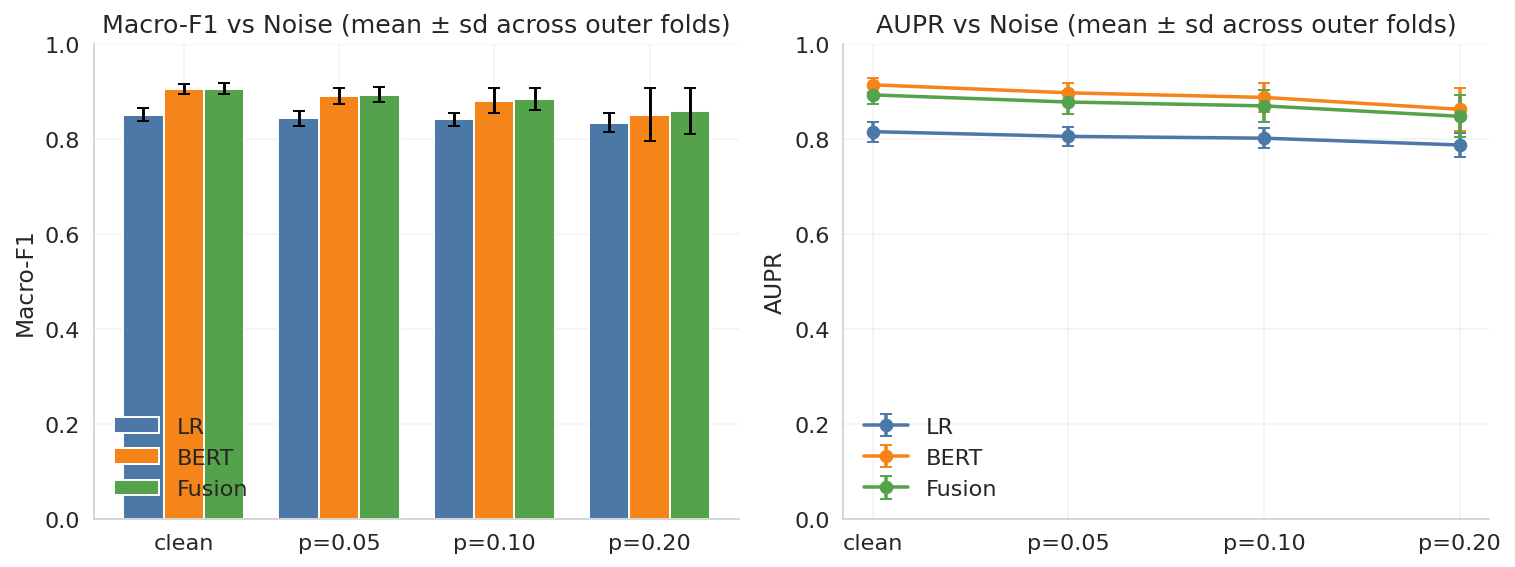

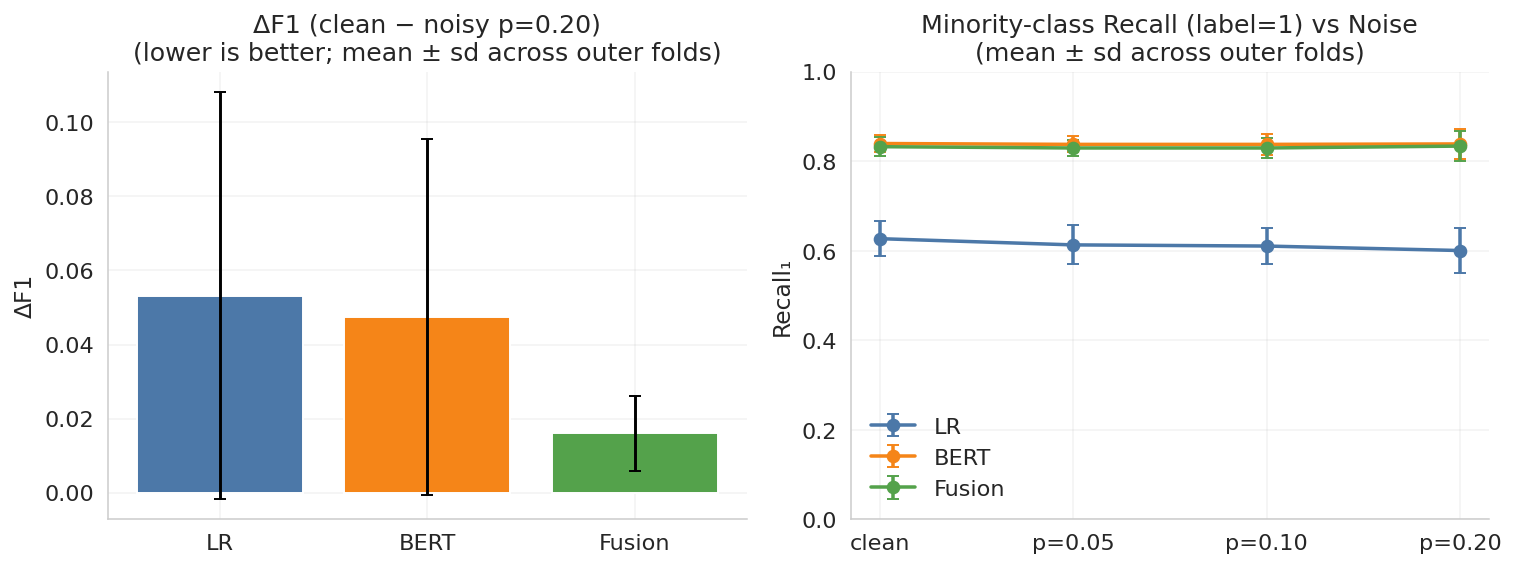

In [ ]:
# =========================
# C7 - Minimal Plots (Figure 1 & 2)
# =========================
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import math


BY_FOLD_DIR = Path("fusion_results/unified/by_fold")
PLOT_DIR = Path("fusion_results/plots"); PLOT_DIR.mkdir(parents=True, exist_ok=True)


SPLIT_ORDER = ["clean", "noisy_p005", "noisy_p010", "noisy_p020"]
SPLIT_LABELS = {"clean":"clean", "noisy_p005":"p=0.05", "noisy_p010":"p=0.10", "noisy_p020":"p=0.20"}

MODEL_ORDER = ["LR", "BERT", "Fusion"]
MODEL_COLORS = {"LR":"#4C78A8", "BERT":"#F58518", "Fusion":"#54A24B"}


def load_by_fold_table(by_fold_dir=BY_FOLD_DIR):
    files = sorted(glob.glob(str(by_fold_dir / "*.csv")))
    if not files:
        raise FileNotFoundError(f"No CSV found in {by_fold_dir}")

    dfs = []
    for f in files:
        df = pd.read_csv(f)

        stem = Path(f).stem  # e.g. "Fusion_clean_fold0"
        parts = stem.split("_")

        if "model" not in df.columns or df["model"].isna().all():
            df["model"] = parts[0] if len(parts) > 0 else None
        if "fold" not in df.columns or df["fold"].isna().all():
            try:
                fold_token = [p for p in parts if p.startswith("fold")]
                df["fold"] = int(fold_token[0].replace("fold","")) if fold_token else None
            except:
                df["fold"] = None
        if "split" not in df.columns or df["split"].isna().all():

            if df["fold"].notna().all():

                if len(parts) >= 3:
                    mid = parts[1:-1]
                    df["split"] = "_".join(mid) if mid else None
            else:

                df["split"] = "_".join(parts[1:]) if len(parts) > 1 else None
        dfs.append(df)

    big = pd.concat(dfs, ignore_index=True)

    big = big[big["model"].isin(MODEL_ORDER)]
    big = big[big["split"].isin(SPLIT_ORDER)]
    return big

def agg_mean_std(big: pd.DataFrame, metric: str):

    need = ["model", "split", metric]
    miss = [c for c in need if c not in big.columns]
    if miss:
        raise KeyError(f"missing columns for agg_mean_std: {miss}")
    g = (
        big[need]
        .groupby(["model", "split"])[metric]
        .agg(mean="mean", std="std")
        .reset_index()
        .rename(columns={"mean": f"{metric}_mean", "std": f"{metric}_std"})
    )

    g["split"] = pd.Categorical(g["split"], categories=SPLIT_ORDER, ordered=True)
    g = g.sort_values(["model", "split"]).reset_index(drop=True)
    return g

def compute_delta_f1(big: pd.DataFrame, noisy_split="noisy_p020"):

    need = ["model", "split", "fold", "f1_macro"]
    miss = [c for c in need if c not in big.columns]
    if miss:
        raise KeyError(f"missing columns for compute_delta_f1: {miss}")
    piv = big.pivot_table(index=["model", "fold"], columns="split", values="f1_macro")
    piv = piv.dropna(subset=["clean", noisy_split], how="any")
    df = (piv["clean"] - piv[noisy_split]).reset_index().rename(columns={0: "delta_f1"})
    df["split"] = noisy_split
    agg = (
        df.groupby("model")["delta_f1"]
        .agg(mean="mean", std="std")
        .reset_index()
        .rename(columns={"mean": "delta_f1_mean", "std": "delta_f1_std"})
    )
    return df, agg

def agg_recall1(big: pd.DataFrame):
    need = ["model", "split", "rec_1"]
    miss = [c for c in need if c not in big.columns]
    if miss:
        raise KeyError(f"missing columns for agg_recall1: {miss}")
    g = (
        big[need]
        .groupby(["model", "split"])["rec_1"]
        .agg(mean="mean", std="std")
        .reset_index()
        .rename(columns={"mean": "rec1_mean", "std": "rec1_std"})
    )
    g["split"] = pd.Categorical(g["split"], categories=SPLIT_ORDER, ordered=True)
    g = g.sort_values(["model", "split"]).reset_index(drop=True)
    return g
    return g

def bar_with_err(ax, x_ticks, series_by_model, err_by_model, width=0.25):
    n = len(MODEL_ORDER)
    idx = np.arange(len(x_ticks))
    for i, m in enumerate(MODEL_ORDER):
        means = series_by_model[m]
        errs  = err_by_model[m]
        ax.bar(idx + (i-(n-1)/2)*width, means, yerr=errs, width=width,
               capsize=3, label=m, color=MODEL_COLORS.get(m, None))
    ax.set_xticks(idx); ax.set_xticklabels(x_ticks)

def line_with_err(ax, x_vals, series_by_model, err_by_model):
    for m in MODEL_ORDER:
        means = series_by_model[m]; errs = err_by_model[m]
        ax.errorbar(x_vals, means, yerr=errs, marker='o', linewidth=1.8, capsize=3,
                    label=m, color=MODEL_COLORS.get(m, None))

big = load_by_fold_table(BY_FOLD_DIR)

# (1) Macro-F1 × Noise
f1_agg = agg_mean_std(big, "f1_macro")
# (2) AUPR × Noise
aupr_agg = agg_mean_std(big, "aupr")
# (3) ΔF1（clean vs noisy_p020）
delta_df, delta_agg = compute_delta_f1(big, noisy_split="noisy_p020")
# (4) Recall_1 × Noise
rec1_agg = agg_recall1(big)


x_labels = [SPLIT_LABELS[s] for s in SPLIT_ORDER]
x_vals = np.arange(len(SPLIT_ORDER))

def to_dict_series(agg_df, mean_col, std_col):
    mean_dict = {m: agg_df[agg_df["model"]==m][mean_col].values.tolist() for m in MODEL_ORDER}
    std_dict  = {m: agg_df[agg_df["model"]==m][std_col].values.tolist()  for m in MODEL_ORDER}
    return mean_dict, std_dict

f1_mean, f1_std = to_dict_series(f1_agg, "f1_macro_mean","f1_macro_std")
aupr_mean, aupr_std = to_dict_series(aupr_agg, "aupr_mean","aupr_std")
rec1_mean, rec1_std = to_dict_series(rec1_agg, "rec1_mean","rec1_std")

# ---------------- Figure 1: F1 + AUPR ----------------
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4.2), dpi=140)


bar_with_err(ax1, x_labels, f1_mean, f1_std, width=0.26)
ax1.set_title("Macro-F1 vs Noise (mean ± sd across outer folds)")
ax1.set_ylabel("Macro-F1")
ax1.set_ylim(0.0, 1.0)
ax1.grid(axis='y', alpha=0.25)
ax1.legend(loc="lower left", frameon=False)


line_with_err(ax2, x_vals, aupr_mean, aupr_std)
ax2.set_xticks(x_vals); ax2.set_xticklabels(x_labels)
ax2.set_title("AUPR vs Noise (mean ± sd across outer folds)")
ax2.set_ylabel("AUPR")
ax2.set_ylim(0.0, 1.0)
ax2.grid(axis='y', alpha=0.25)
ax2.legend(loc="lower left", frameon=False)

fig1.tight_layout()
fig1.savefig(PLOT_DIR/"fig1_f1_aupr.png", bbox_inches="tight")

# ---------------- Figure 2: ΔF1 + Recall1 ----------------
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(11, 4.2), dpi=140)

idx = np.arange(len(MODEL_ORDER))
ax3.bar(idx, delta_agg["delta_f1_mean"], yerr=delta_agg["delta_f1_std"], capsize=3,
        color=[MODEL_COLORS.get(m,None) for m in MODEL_ORDER])
ax3.set_xticks(idx); ax3.set_xticklabels(MODEL_ORDER)
ax3.set_title("ΔF1 (clean − noisy p=0.20)\n(lower is better; mean ± sd across outer folds)")
ax3.set_ylabel("ΔF1")
ax3.grid(axis='y', alpha=0.25)


line_with_err(ax4, x_vals, rec1_mean, rec1_std)
ax4.set_xticks(x_vals); ax4.set_xticklabels(x_labels)
ax4.set_title("Minority-class Recall (label=1) vs Noise\n(mean ± sd across outer folds)")
ax4.set_ylabel("Recall₁")
ax4.set_ylim(0.0, 1.0)
ax4.grid(axis='y', alpha=0.25)
ax4.legend(loc="lower left", frameon=False)

fig2.tight_layout()
fig2.savefig(PLOT_DIR/"fig2_deltaF1_recall1.png", bbox_inches="tight")

print("[C7] Plots saved to:", PLOT_DIR)


Saved to: fusion_results/plots/figure_extra_2x2_large.png


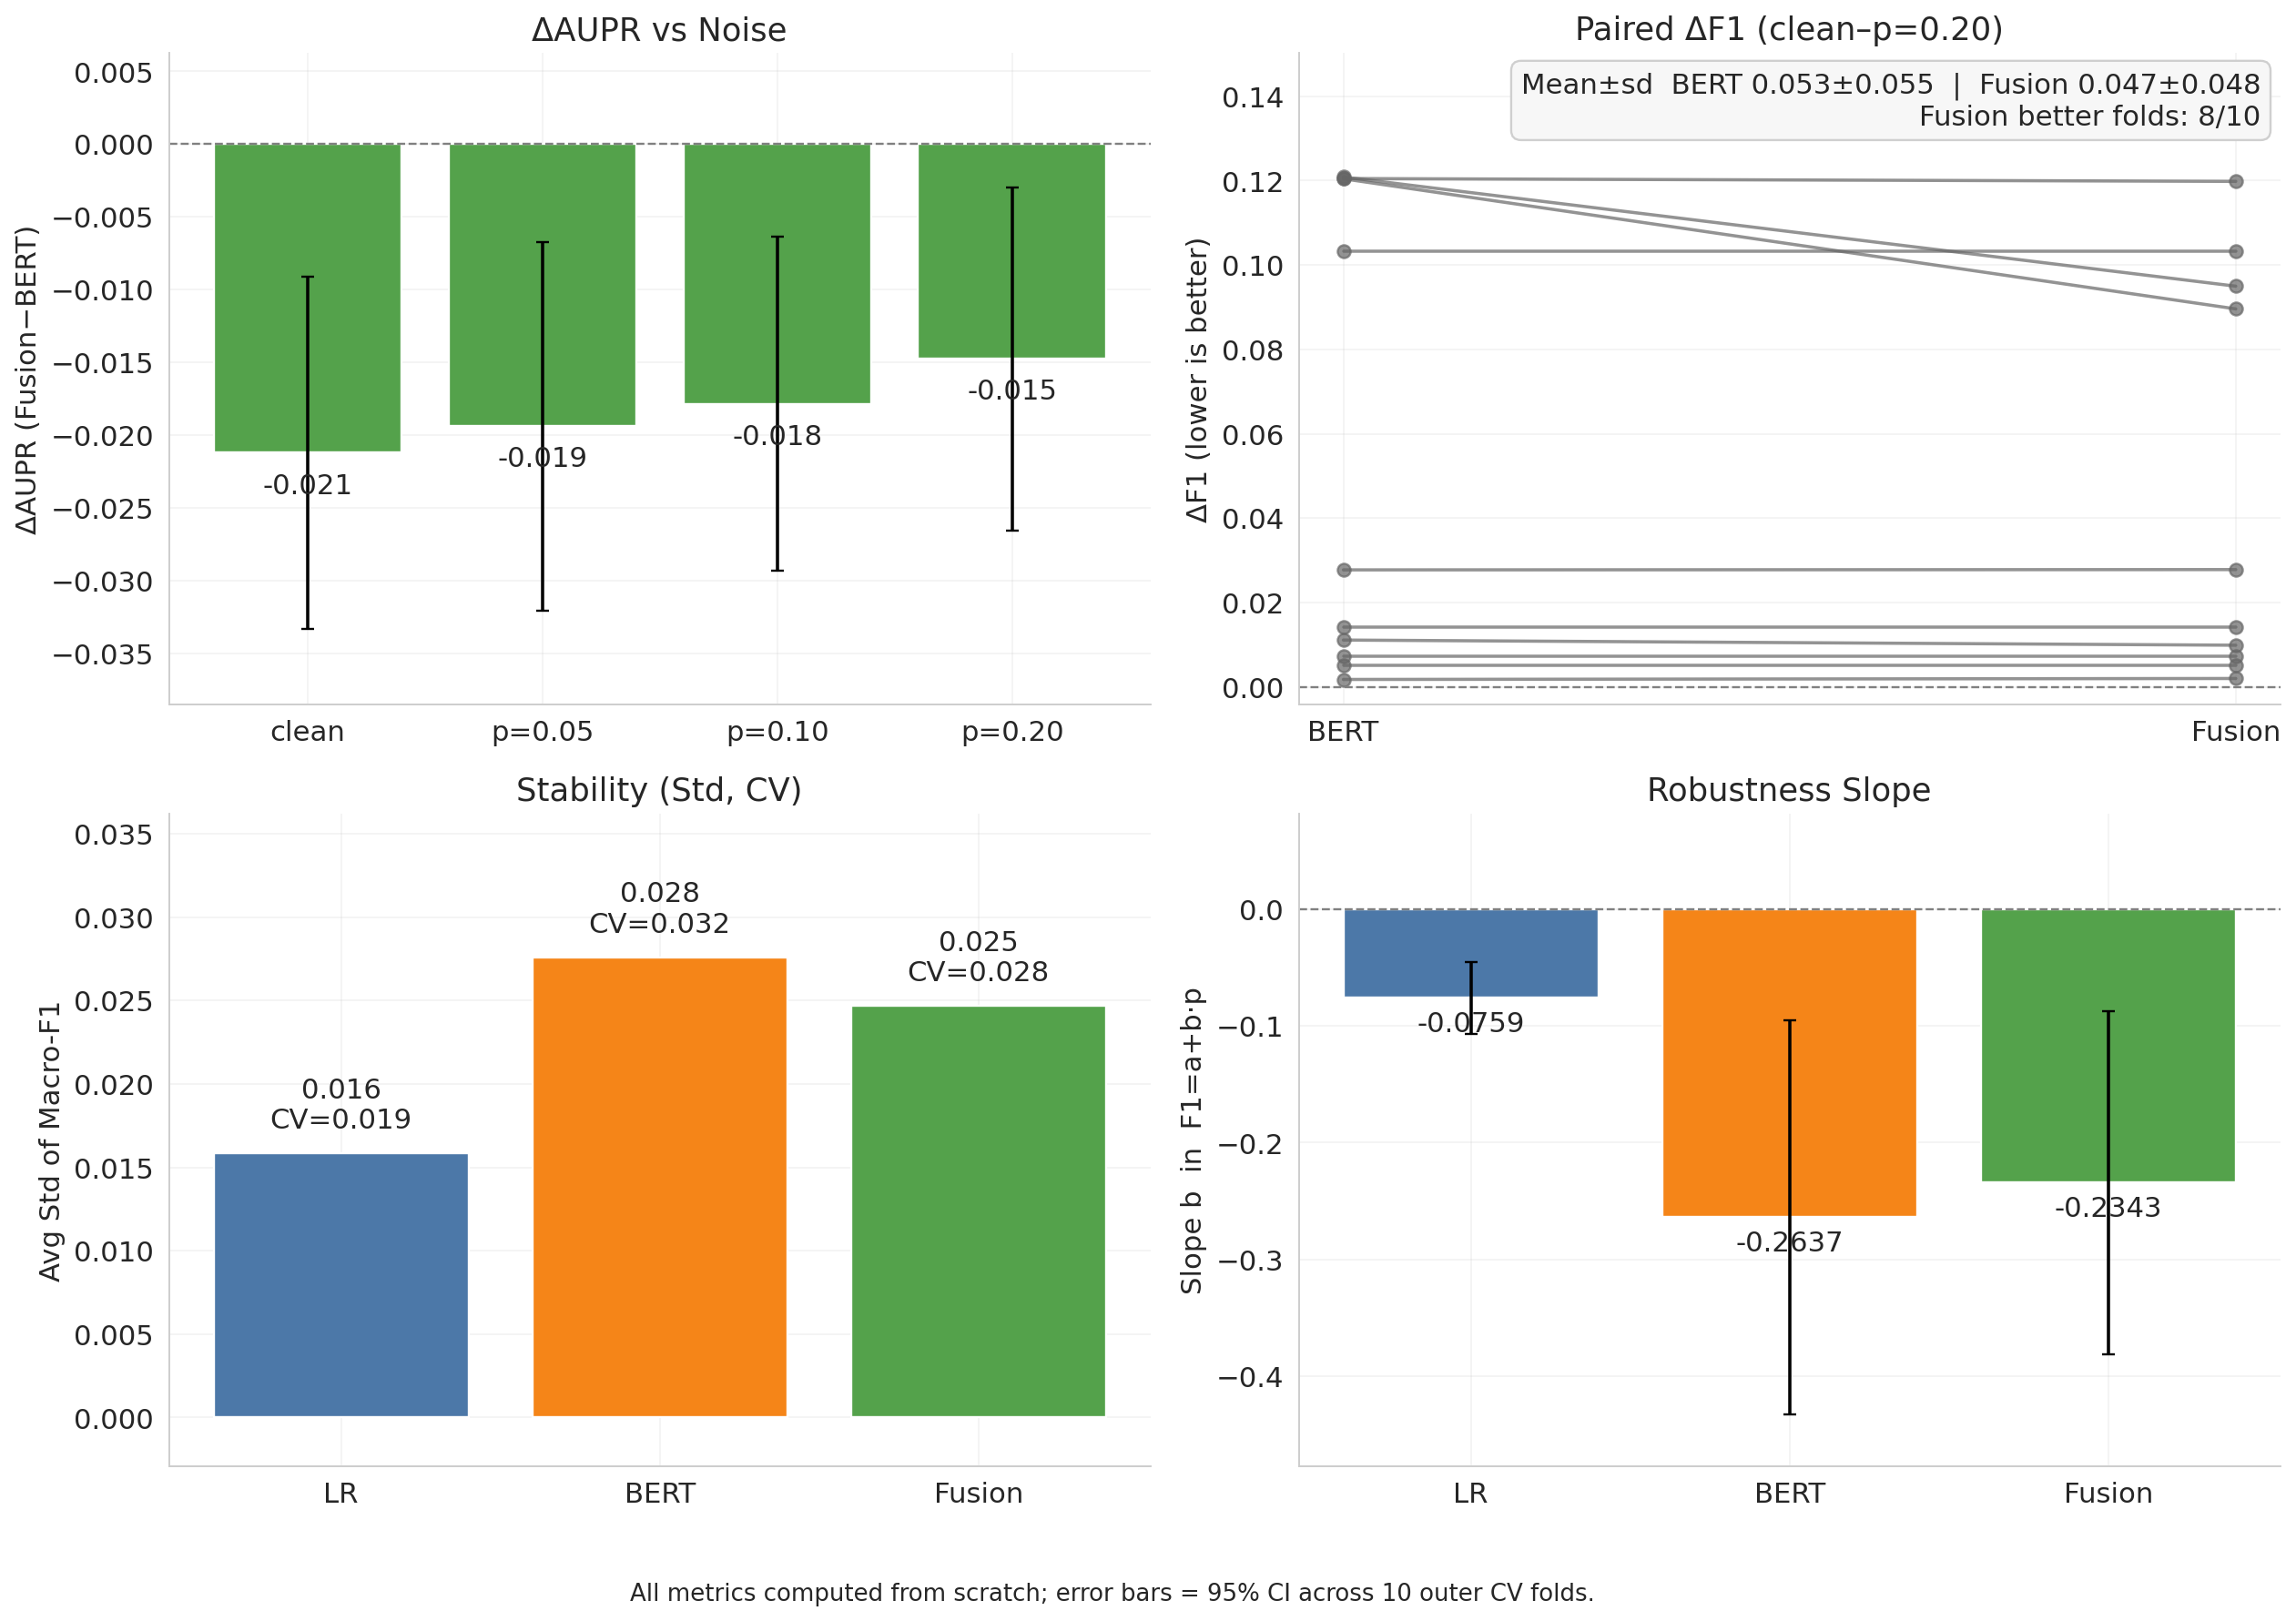

In [ ]:

from pathlib import Path
import pandas as pd, numpy as np, matplotlib.pyplot as plt, glob


LAYOUT  = "2x2"   # "2x2" or "1x4"
USE_CI  = True    # True: 95%CI; False: ±sd
N_OUTER = 10      # outer folds for CI

BY_FOLD_DIR = Path("fusion_results/unified/by_fold")
PLOT_DIR    = Path("fusion_results/plots"); PLOT_DIR.mkdir(parents=True, exist_ok=True)

SPLIT_ORDER  = ["clean","noisy_p005","noisy_p010","noisy_p020"]
SPLIT_LABELS = {"clean":"clean","noisy_p005":"p=0.05","noisy_p010":"p=0.10","noisy_p020":"p=0.20"}
P_VALUE      = {"clean":0.00,"noisy_p005":0.05,"noisy_p010":0.10,"noisy_p020":0.20}
MODELS       = ["LR","BERT","Fusion"]
COLORS       = {"LR":"#4C78A8","BERT":"#F58518","Fusion":"#54A24B"}


plt.rcParams.update({
    "figure.dpi": 170,
    "font.size": 13,
    "axes.titlesize": 15,
    "axes.labelsize": 13,
    "axes.grid": True, "grid.alpha": 0.22,
    "axes.spines.top": False, "axes.spines.right": False
})


def load_by_fold_table(by_fold_dir=BY_FOLD_DIR):
    files = sorted(glob.glob(str(by_fold_dir/"*.csv")))
    if not files:
        raise FileNotFoundError(f"No CSV found in {by_fold_dir}")
    dfs=[]
    for f in files:
        df = pd.read_csv(f)
        df = df.loc[:, ~df.columns.astype(str).str.match(r"^Unnamed:|^index$")]
        stem = Path(f).stem; parts = stem.split("_")
        if "model" not in df.columns or df["model"].isna().all():
            df["model"] = parts[0] if parts else None
        if "fold" not in df.columns or df["fold"].isna().all():
            tok = [p for p in parts if p.startswith("fold")]
            df["fold"] = int(tok[0].replace("fold","")) if tok else None
        if "split" not in df.columns or df["split"].isna().all():
            if len(parts)>=3: df["split"] = "_".join(parts[1:-1])
            elif len(parts)>=2: df["split"] = parts[1]
            else: df["split"] = None
        dfs.append(df)
    big = pd.concat(dfs, ignore_index=True)
    big = big[big["model"].isin(MODELS)]
    big = big[big["split"].isin(SPLIT_ORDER)]
    big["split"] = pd.Categorical(big["split"], categories=SPLIT_ORDER, ordered=True)
    return big.sort_values(["model","split","fold"]).reset_index(drop=True)

def err_from_sd(sd):
    return 1.96*sd/np.sqrt(N_OUTER) if USE_CI else sd

def lift_ylim_for_labels(ax, top_pad_frac=0.15, bottom_pad_frac=0.10):

    ymin, ymax = ax.get_ylim()
    yr = ymax - ymin
    ax.set_ylim(ymin - yr*bottom_pad_frac, ymax + yr*top_pad_frac)

try:
    big
except NameError:
    big = load_by_fold_table()

for c in ["model","split","fold","f1_macro","aupr"]:
    if c not in big.columns:
        raise KeyError(f"Missing column: {c}")


da_rows=[]
for split in SPLIT_ORDER:
    sub = big[big["split"]==split].pivot_table(index="fold", columns="model", values="aupr")
    sub = sub.reindex(columns=["BERT","Fusion"]).dropna()
    d = sub["Fusion"] - sub["BERT"]
    da_rows.append({"split":split, "mean":d.mean(), "sd":d.std(), "n":len(d), "pos_frac":(d>0).mean()})
delta_aupr = pd.DataFrame(da_rows).sort_values("split")


noisy_s = "noisy_p020"
piv = big.pivot_table(index=["model","fold"], columns="split", values="f1_macro")
piv = piv.dropna(subset=["clean", noisy_s], how="any")
delta = (piv["clean"] - piv[noisy_s]).reset_index().rename(columns={0:"delta_f1"})
pair  = delta.pivot(index="fold", columns="model", values="delta_f1")[["BERT","Fusion"]].dropna()
mu_b, sd_b = pair["BERT"].mean(),  pair["BERT"].std()
mu_f, sd_f = pair["Fusion"].mean(), pair["Fusion"].std()
better_cnt, total_cnt = int((pair["Fusion"] <= pair["BERT"]).sum()), int(len(pair))
pair_plot = pair.assign(diff=pair["BERT"]-pair["Fusion"]).sort_values("diff", ascending=False)


stab_rows=[]
for m in MODELS:
    sdf = big[big["model"]==m].groupby(["split","fold"])["f1_macro"].mean().reset_index()
    per = sdf.groupby("split")["f1_macro"].agg(["mean","std"]).reset_index()
    per = per[per["std"].notna()]
    stab_rows.append({
        "model": m,
        "avg_std": per["std"].mean(),
        "avg_cv" : (per["std"]/per["mean"]).mean()
    })
stab = pd.DataFrame(stab_rows).set_index("model").loc[MODELS]


P_VALS = np.array([P_VALUE[s] for s in SPLIT_ORDER], dtype=float)
slope_rows=[]
for m in MODELS:
    for fd, g in big[big["model"]==m].groupby("fold"):
        g = g.dropna(subset=["split","f1_macro"])
        if set(SPLIT_ORDER).issubset(set(g["split"].unique())):
            y = g.set_index("split").loc[SPLIT_ORDER,"f1_macro"].values.astype(float)
            xm, ym = P_VALS.mean(), y.mean()
            b = ((P_VALS-xm)*(y-ym)).sum() / ((P_VALS-xm)**2).sum()
            slope_rows.append({"model":m,"fold":fd,"slope":b})
slope_df  = pd.DataFrame(slope_rows)
slope_agg = slope_df.groupby("model")["slope"].agg(["mean","std"]).reindex(MODELS)


if LAYOUT == "1x4":
    fig, axes = plt.subplots(1, 4, figsize=(25, 6))
    axA, axB, axC, axD = axes
    plt.subplots_adjust(left=0.06, right=0.99, top=0.90, bottom=0.12, wspace=0.30)
else:  # 2x2
    fig, axes = plt.subplots(2, 2, figsize=(15.5, 11))
    axA, axB = axes[0]
    axC, axD = axes[1]
    plt.subplots_adjust(left=0.08, right=0.99, top=0.92, bottom=0.10, wspace=0.30, hspace=0.38)

ci_lab = "95% CI" if USE_CI else "sd"

# ---------- A：ΔAUPR ----------
x = np.arange(len(delta_aupr))
y = delta_aupr["mean"].values
e = np.array([err_from_sd(s) for s in delta_aupr["sd"].values])
bars = axA.bar(x, y, yerr=e, capsize=3, color="#54A24B")
axA.axhline(0, color="gray", linestyle="--", linewidth=1)
axA.set_xticks(x); axA.set_xticklabels([SPLIT_LABELS[s] for s in delta_aupr["split"]])
axA.set_ylabel("ΔAUPR = AUPR(Fusion) − AUPR(BERT)")
axA.set_title(f"A) ΔAUPR vs Noise (mean ± {ci_lab}, n={N_OUTER})")
lift_ylim_for_labels(axA, top_pad_frac=0.18)

ylim = axA.get_ylim(); offset = (ylim[1]-ylim[0])*0.03
for i,b in enumerate(bars):
    val = y[i]
    axA.text(b.get_x()+b.get_width()/2, val + (offset if val>=0 else -offset),
             f"{val:+.003f}", ha="center", va="bottom" if val>=0 else "top")


for fd, row in pair_plot.iterrows():
    axB.plot([0,1], [row["BERT"], row["Fusion"]],
             marker="o", color="#666666", alpha=0.7)
axB.set_xticks([0,1]); axB.set_xticklabels(["BERT","Fusion"])
axB.axhline(0, color="gray", linestyle="--", linewidth=1)
axB.set_ylabel("ΔF1 (clean − noisy p=0.20)  [lower is better]")
axB.set_title("B) Per-fold Paired Robustness: BERT → Fusion")

ymin, ymax = axB.get_ylim()
axB.set_ylim(ymin, ymax + (ymax-ymin)*0.18)

box = (f"Mean±sd  BERT {mu_b:.3f}±{sd_b:.3f}  |  Fusion {mu_f:.3f}±{sd_f:.3f}\n"
       f"Fusion better folds: {better_cnt}/{total_cnt}")
axB.text(0.98, 0.97, box, transform=axB.transAxes, ha="right", va="top",
         bbox=dict(boxstyle="round,pad=0.35", fc="#f7f7f7", ec="#cfcfcf"))


idx = np.arange(len(MODELS))
bars = axC.bar(idx, stab["avg_std"].values, color=[COLORS[m] for m in MODELS])
axC.set_xticks(idx); axC.set_xticklabels(MODELS)
axC.set_ylabel("Average Std of Macro-F1 across folds  [lower is better]")
axC.set_title("C) Stability by Model (std), CV on bars")
lift_ylim_for_labels(axC, top_pad_frac=0.25)
ylim = axC.get_ylim(); offset = (ylim[1]-ylim[0])*0.03
for i,b in enumerate(bars):
    v  = b.get_height()
    axC.text(b.get_x()+b.get_width()/2, v + offset,
             f"{v:.3f}\nCV={stab.iloc[i]['avg_cv']:.3f}",
             ha="center", va="bottom")

# ---------- D：Robustness Slope ----------
y = slope_agg["mean"].values
e = np.array([err_from_sd(s) for s in slope_agg["std"].values])
bars = axD.bar(idx, y, yerr=e, capsize=3, color=[COLORS[m] for m in MODELS])
axD.axhline(0, color="gray", linestyle="--", linewidth=1)
axD.set_xticks(idx); axD.set_xticklabels(MODELS)
axD.set_ylabel("Slope b in F1 = a + b·p   [closer to 0 ⇒ more robust]")
axD.set_title(f"D) Robustness Slope by Model (mean ± {ci_lab})")
lift_ylim_for_labels(axD, top_pad_frac=0.18, bottom_pad_frac=0.05)
ylim = axD.get_ylim(); offset = (ylim[1]-ylim[0])*0.02
for i,b in enumerate(bars):
    val = b.get_height()
    axD.text(b.get_x()+b.get_width()/2, val + (offset if val>=0 else -offset),
             f"{val:+.4f}", ha="center", va="bottom" if val>=0 else "top")

fig.suptitle("Supplementary Results (all metrics computed from scratch; error bars across 10 outer folds)",
             y=0.995, fontsize=15)
ci_lab = "95% CI" if USE_CI else "sd"


axA.set_title("ΔAUPR vs Noise")
axB.set_title("Paired ΔF1 (clean–p=0.20)")
axC.set_title("Stability (Std, CV)")
axD.set_title("Robustness Slope")


axA.set_ylabel("ΔAUPR (Fusion−BERT)")
axB.set_ylabel("ΔF1 (lower is better)")
axC.set_ylabel("Avg Std of Macro-F1")
axD.set_ylabel("Slope b  in  F1=a+b·p")

try:
    fig._suptitle.set_text("")
except Exception:
    pass
fig.text(
    0.5, 0.01,
    f"All metrics computed from scratch; error bars = {ci_lab} across {N_OUTER} outer CV folds.",
    ha="center", va="bottom", fontsize=11
)


fig.tight_layout(rect=[0.03, 0.05, 1, 0.98])


out_name = "figure_extra_2x2_large.png" if LAYOUT=="2x2" else "figure_extra_1x4_large.png"
fig.savefig(PLOT_DIR/out_name, bbox_inches="tight")
print("Saved to:", (PLOT_DIR/out_name).as_posix())


## C8: Repro Manifest

In [ ]:
# C8 - Repro Manifest
import platform, sys, torch, transformers, sklearn, cupy
print({
    "seed": SEED,
    "model_name": MODEL_NAME,
    "subset": int(SUBSET_N),
    "outer_folds": int(N_OUTER), "inner_folds": int(N_INNER),
    "grids": {"LR": LR_PARAM_GRID, "BERT": BERT_PARAM_GRID, "Fusion": FUSION_PARAM_GRID},
    "lib_versions": {
        "python": sys.version.split()[0], "platform": platform.platform(),
        "pytorch": torch.__version__, "transformers": transformers.__version__,
        "sklearn": sklearn.__version__, "cupy": cupy.__version__,
    },
    "paths": {"UNI_OUT": str(UNI_OUT), "BY_FOLD_DIR": str(BY_FOLD_DIR)}
})

{'seed': 42, 'model_name': 'bert-base-uncased', 'subset': 30000, 'outer_folds': 10, 'inner_folds': 3, 'grids': {'LR': {'C': [0.01, 0.1, 0.5, 1.0, 10.0, 100.0], 'penalty': ['l2']}, 'BERT': {'lr': [3e-05, 5e-05, 7e-05], 'batch': [16], 'epochs': [2]}, 'Fusion': {'alpha': [0.0, 0.2, 0.5, 0.8, 1.0], 'K': [32], 'temperature': [0.05, 0.1, 0.15], 'tau': [0.5]}}, 'lib_versions': {'python': '3.12.12', 'platform': 'Linux-6.6.105+-x86_64-with-glibc2.35', 'pytorch': '2.8.0+cu126', 'transformers': '4.57.0', 'sklearn': '1.6.1', 'cupy': '13.3.0'}, 'paths': {'UNI_OUT': 'fusion_results/unified', 'BY_FOLD_DIR': 'unified/by_fold'}}
